# DivPs analysis Chain B45 OVA data 50000 random subsmpl shuffled frequencies


TCRDivER analysis of the Murine dataset with Blosum45 distance used as TCR distance metric with shuffled CDR3 frequencies. 

**Instructions** 

Set path to working directory which should contain: 

* divP_tsv directory: containting all the diversities calculated at varying $q$ and $\lambda$s the TCRDivER algorithm outputs
* filtered directory: containing all the filetered TCR repertoires the TCRDivER algorithm outputs


In [79]:
from os import listdir
from os.path import isfile, join
import os
import re
import pandas as pd
from collections import defaultdict
from collections import OrderedDict
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import decomposition
from sklearn.metrics import accuracy_score

In [80]:
def plt_divP(divP_df, sample_name, time, treatment, wdir_path): 
    divP_df_long = pd.melt(divP_df, "q", var_name = "Lambda", value_name = "DqZ")
    qs_label = [q if q != "7" else "$\infty$" for q in list(map(str, divP_df["q"]))]
    sns.color_palette("colorblind")
    plt.figure(figsize=(6,8))
    ax =sns.lineplot(x="q", y="DqZ", data=divP_df_long, hue = "Lambda", markers=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.fill_between(divP_df["q"].values, divP_df["16.0"].values, divP_df["identity"].values, 
                 facecolor='red', alpha = 0.2)
    
    plt.xticks(ticks = divP_df["q"].values, labels = qs_label, fontsize = 13)
    plt.yticks(ticks = range(0,13), fontsize = 13)
    plt.ylim(top=12)
    plt.xlabel("q", fontsize = 20)
    plt.ylabel("ln($D(q,\lambda)$)", fontsize = 20)
    plt.title(sample_name, fontsize = 20)
    if not os.path.isdir(wdir_path+"divPs/"):
        os.makedirs(wdir_path+"divPs/", exist_ok=False)
    plt.savefig(wdir_path + "divPs/"+ sample_name + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
    return plt

In [81]:
def calculate_area_between_curves(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas.reverse()
    area_dict = OrderedDict()
    for index,first in list(enumerate(lambdas)):
        for second in lambdas[index+1:]:
            area = np.trapz(divP_df[first].values , x=divP_df["q"].values) - np.trapz(divP_df[second].values , x=divP_df["q"].values)
            area_dict["_".join([first, second, "area"])] = area
    return area_dict



In [82]:
def calculate_slopes(divP_df):
    lambdas = [lb for lb in list(divP_df) if lb != "q"]
    lambdas = [lb for lb in lambdas if lb != "0.0"]
    lambdas.reverse()
    slope_dict = OrderedDict()
    for lb in lambdas: 
        slope_dict["_".join(["0_1_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[1, lb]
        slope_dict["_".join(["0_2_slope", lb])] = divP_df.loc[0, lb]-divP_df.loc[2, lb]
        slope_dict["_".join(["1_2_slope", lb])] = divP_df.loc[1, lb]-divP_df.loc[2, lb]
    return slope_dict

In [83]:
def calculate_avg_delta_lambda_05_00(divP_df):
    avg_delta_lambda = divP_df[["0.0","0.1","0.2", "0.3", "0.4", "0.5"]].diff(axis = 1).mean().mean()
    return avg_delta_lambda

In [84]:
def make_divP_one_row_df(divP_df):
    divP_df_wo_L0 = divP_df.drop("0.0", axis = 1)
    list_of_lambdas = [lmbd for lmbd in list(divP_df_wo_L0) if lmbd != "q"]
    list_of_dqz = list()
    for lmbd in list_of_lambdas:
        for qu in divP_df_wo_L0["q"]:
            if qu == 7: 
                qu = 11
                qu_name = "infinity"
            qu_name = str(qu)
            list_of_dqz.append(("L_"+ lmbd + "_q_" +qu_name, divP_df_wo_L0.loc[qu,lmbd]))
    sample_dqz = pd.DataFrame(list_of_dqz).T
    sample_dqz.columns = sample_dqz.iloc[0]
    sample_dqz = sample_dqz.drop(sample_dqz.index[0])
    sample_dqz = sample_dqz.reset_index(drop = "True")
    return sample_dqz



In [85]:
# Set path to working directory:
wdir_path = "/Users/milvu/Documents/OneDrive - Danmarks Tekniske Universitet/TCR_analysis/TCRDivER_algorithm/datasets_divP_calculated/Chain_OVAexpt_data_B45_50000_random_subsmpl/OVAData1_shuffled_freqs/"
#set path to metadata excel file
path_to_metadata ="../metadata/Cinelli_et_al_NF_MouseData_OVA_data_1.csv"


Let's make the metadata dataframe from the filenames themselves by establishing some criteria. 

# OVA data 1

In [86]:
# Read in metadata: 
mddf = pd.read_csv(wdir_path+ path_to_metadata, sep = ",")
mddf = mddf[["OVA data 1", "library", "in-vivo treatment", "post-immunisation time", "sample type"]]
mddf.columns = ["sample_name", "library", "treatment", "post_imm_time", "sample_type"]
mddf.loc[(mddf.post_imm_time == 'm2'),'post_imm_time']='d60'
mddf.sort_values(by=["post_imm_time", "treatment"], inplace=True)
mddf = mddf.reset_index(drop = True)

In [87]:
#read in filtered filenames and count unique CDR3s
filtered_fpath = wdir_path + "filtered/"
files = [f for f in listdir(filtered_fpath) if isfile(join(filtered_fpath, f))]
files = [f for f in listdir(filtered_fpath) if f.endswith(".tsv")]
unique_CDR3s_dict = defaultdict()
column_names = ["sample_name", "age", "immunisation", "unique_CDR3s"]
for file in files: 
    num_lines = sum(1 for line in open(filtered_fpath+file))
    unique_CDR3s_dict["_".join(file.split("_")[:-1])]=num_lines

files

['SB2_GTC_clean_cdr3_filtered.tsv',
 'SB2_CCG_clean_cdr3_filtered.tsv',
 'SB2_ATT_clean_cdr3_filtered.tsv',
 'SB1_CAC_clean_cdr3_filtered.tsv',
 'SB2_ACC_clean_cdr3_filtered.tsv',
 'SB1_TAT_clean_cdr3_filtered.tsv',
 'EAE1B_CCG_clean_cdr3_filtered.tsv',
 'EAE1B_TTG_clean_cdr3_filtered.tsv',
 'SB1_TGC_clean_cdr3_filtered.tsv',
 'SB2_GCT_clean_cdr3_filtered.tsv',
 'SB1_GCT_clean_cdr3_filtered.tsv',
 'SB1_GAG_clean_cdr3_filtered.tsv',
 'EAE1A_TTG_clean_cdr3_filtered.tsv',
 'SB1_AGG_clean_cdr3_filtered.tsv',
 'SB1_CTA_clean_cdr3_filtered.tsv',
 'SB1_AAA_clean_cdr3_filtered.tsv',
 'SB1_TCA_clean_cdr3_filtered.tsv',
 'CPX1A_GGA_clean_cdr3_filtered.tsv',
 'SB1_ACC_clean_cdr3_filtered.tsv',
 'CPX1A_TTG_clean_cdr3_filtered.tsv',
 'CPX1B_CAC_clean_cdr3_filtered.tsv',
 'SB1_ATT_clean_cdr3_filtered.tsv',
 'SB1_CCG_clean_cdr3_filtered.tsv',
 'SB2_CAC_clean_cdr3_filtered.tsv',
 'SB1_TTG_clean_cdr3_filtered.tsv',
 'SB1_GTC_clean_cdr3_filtered.tsv',
 'SB2_CGT_clean_cdr3_filtered.tsv',
 'EAE1A_GGA_clea

In [88]:
unique_CDR3_list = [unique_CDR3s_dict["".join([row["sample_name"], "_clean_cdr3"])] for index, row in mddf.iterrows()]
mddf["unique_CDR3s"] = unique_CDR3_list
mddf

sample_name library  treatment post_imm_time sample_type  unique_CDR3s
0    CPX1A_GGA     CPX  untreated            d0      spleen         32295
1    CPX1A_TTG     CPX  untreated            d0      spleen         30541
2    CPX1B_CAC     CPX  untreated            d0      spleen         30131
3    EAE1A_GGA     EAE  untreated            d0      spleen         28170
4    EAE1A_TTG     EAE  untreated            d0      spleen         28699
5    EAE1B_CCG     EAE  untreated            d0      spleen         14866
6    EAE1B_TTG     EAE  untreated            d0      spleen         21506
7      SB1_TGC     SB1  untreated            d0      spleen         21727
8      SB1_ACC     SB1        CFA           d14      spleen         27156
9      SB1_CTA     SB1        CFA           d14      spleen         25445
10     SB1_GCT     SB1        CFA           d14      spleen         25435
11     SB1_AGG     SB1        OVA           d14      spleen         33190
12     SB1_GAG     SB1        OVA           d14      spleen         27132
13     SB1_TAT     SB1        OVA           d14      spleen         32121
14     SB1_AAA     SB1        CFA            d5      spleen         30400
15     SB1_CCG     SB1        CFA            d5      spleen         29493
16     SB1_TTG     SB1        CFA            d5      spleen         32263
17     SB1_ATT     SB1        OVA            d5      spleen         31315
18     SB1_CAC     SB1        OVA            d5      spleen         30520
19     SB1_GTC     SB1        OVA            d5      spleen         32077
20     SB2_ATT     SB2        CFA           d60      spleen         19626
21     SB2_CCG     SB2        CFA           d60      spleen         23146
22     SB2_CGT     SB2        CFA           d60      spleen         15539
23     SB2_CAC     SB2        OVA           d60      spleen         16251
24     SB2_GCT     SB2        OVA           d60      spleen         20608
25     SB2_GTC     SB2        OVA           d60      spleen         17966

## Plot Diversity Profiles for individual samples 

In [89]:
# load filenames: 
divP_fpath = wdir_path + "divP_tsv/"
divP_files = [f for f in listdir(divP_fpath) if isfile(join(divP_fpath, f))]
divP_files = [f for f in divP_files if f.endswith('tsv')]
divP_files = [re.sub('\.tsv$', '', f) for f in divP_files]
divP_files.sort()
divP_files = [f for f in divP_files]

divP_files

['CPX1A_GGA_clean_cdr3_divP',
 'CPX1A_TTG_clean_cdr3_divP',
 'CPX1B_CAC_clean_cdr3_divP',
 'EAE1A_GGA_clean_cdr3_divP',
 'EAE1A_TTG_clean_cdr3_divP',
 'EAE1B_CCG_clean_cdr3_divP',
 'EAE1B_TTG_clean_cdr3_divP',
 'SB1_AAA_clean_cdr3_divP',
 'SB1_ACC_clean_cdr3_divP',
 'SB1_AGG_clean_cdr3_divP',
 'SB1_ATT_clean_cdr3_divP',
 'SB1_CAC_clean_cdr3_divP',
 'SB1_CCG_clean_cdr3_divP',
 'SB1_CTA_clean_cdr3_divP',
 'SB1_GAG_clean_cdr3_divP',
 'SB1_GCT_clean_cdr3_divP',
 'SB1_GTC_clean_cdr3_divP',
 'SB1_TAT_clean_cdr3_divP',
 'SB1_TGC_clean_cdr3_divP',
 'SB1_TTG_clean_cdr3_divP',
 'SB2_ATT_clean_cdr3_divP',
 'SB2_CAC_clean_cdr3_divP',
 'SB2_CCG_clean_cdr3_divP',
 'SB2_CGT_clean_cdr3_divP',
 'SB2_GCT_clean_cdr3_divP',
 'SB2_GTC_clean_cdr3_divP']

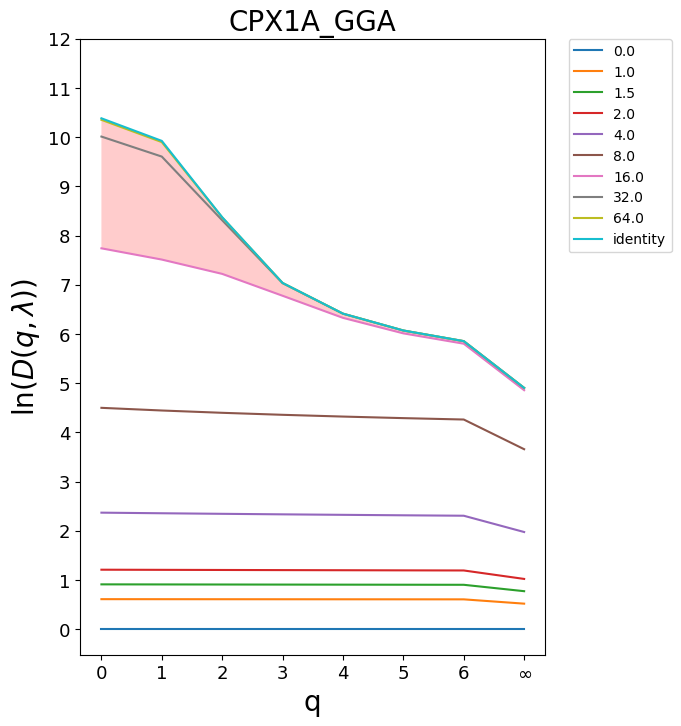

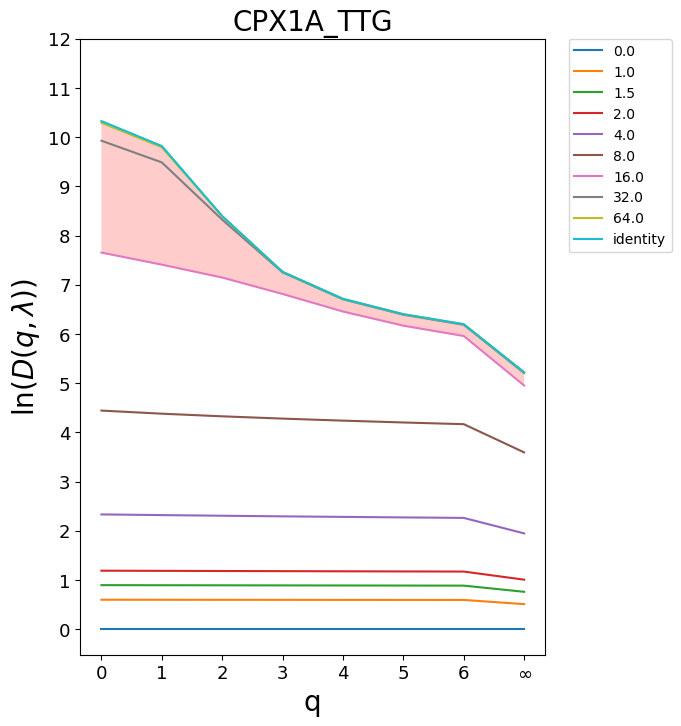

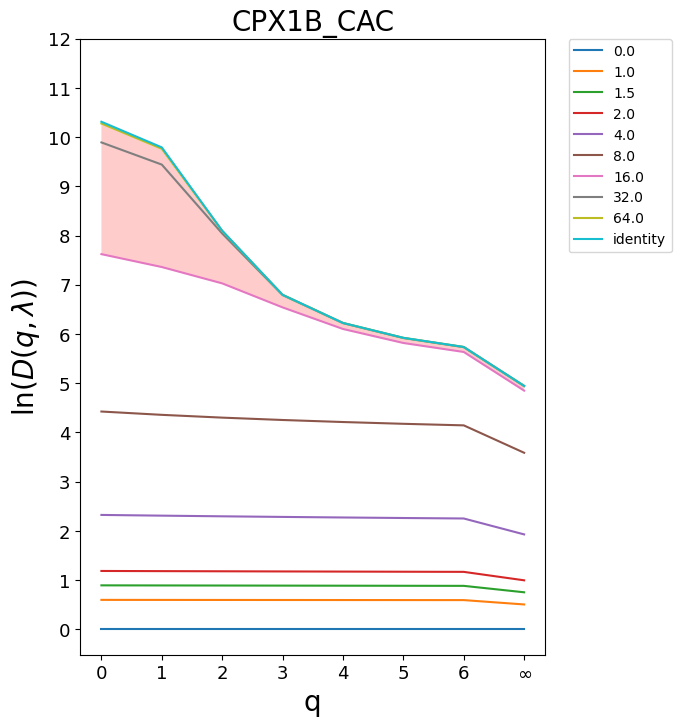

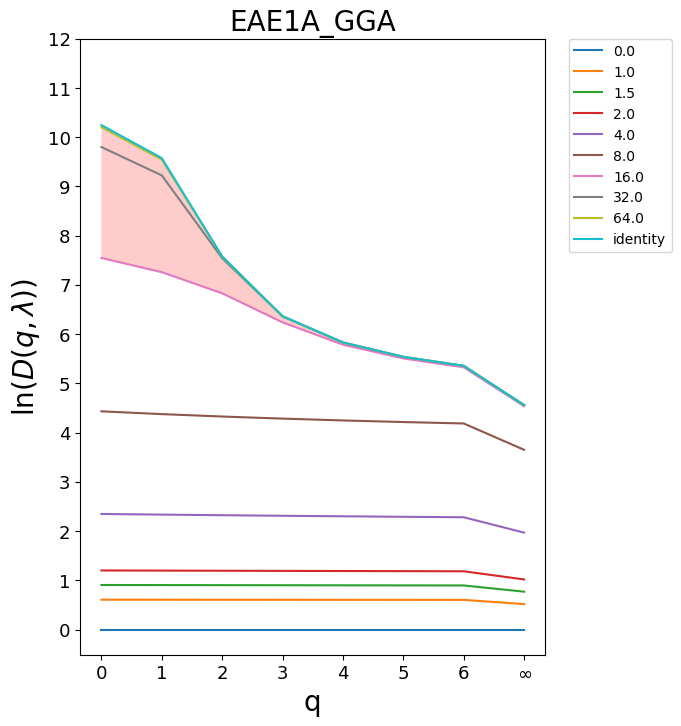

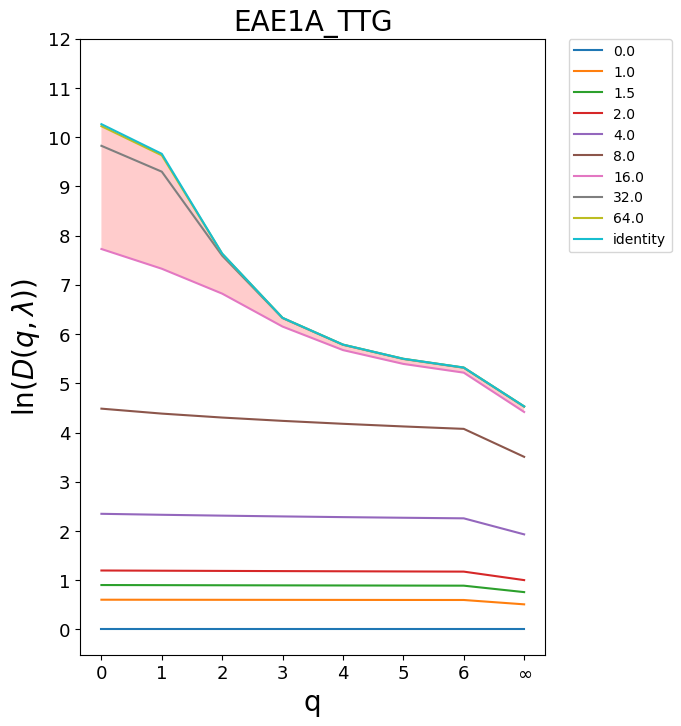

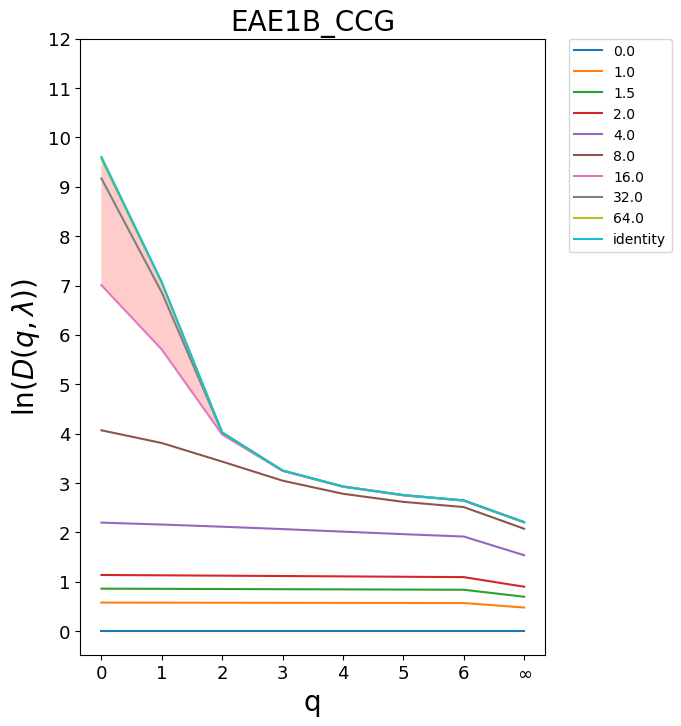

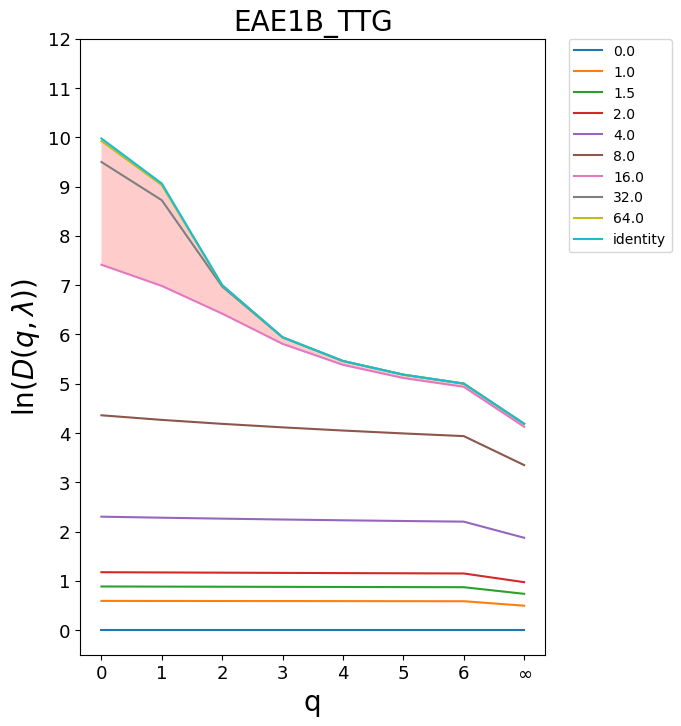

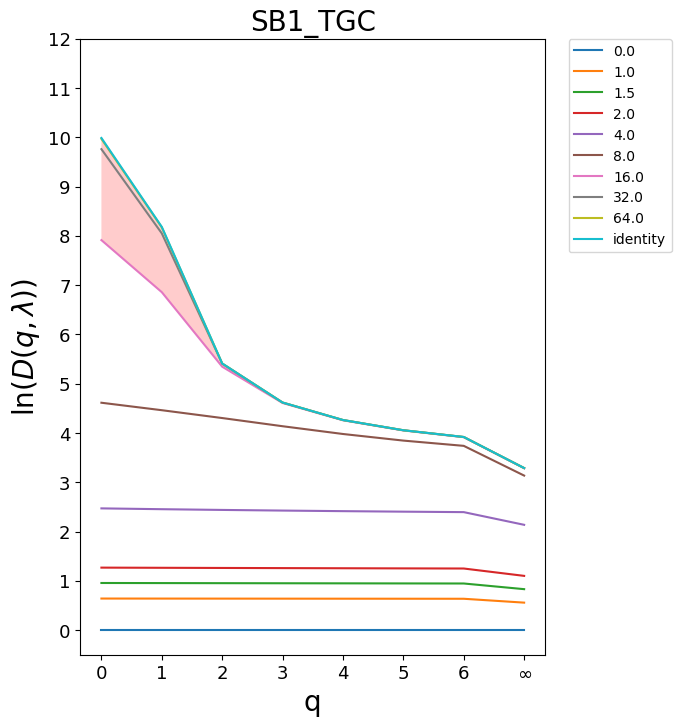

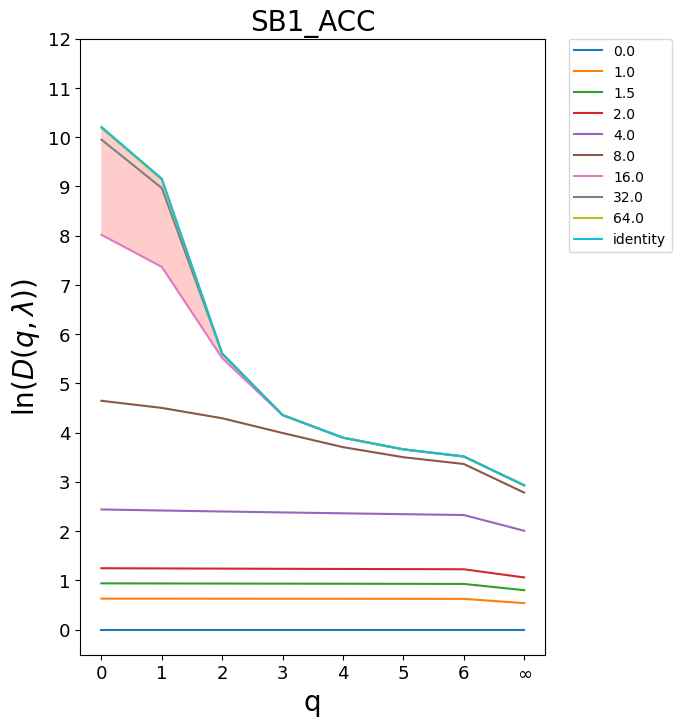

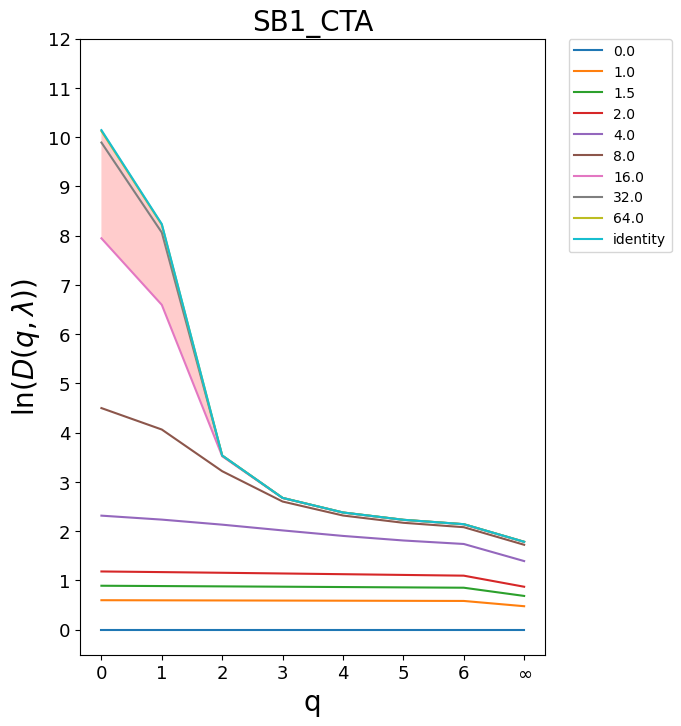

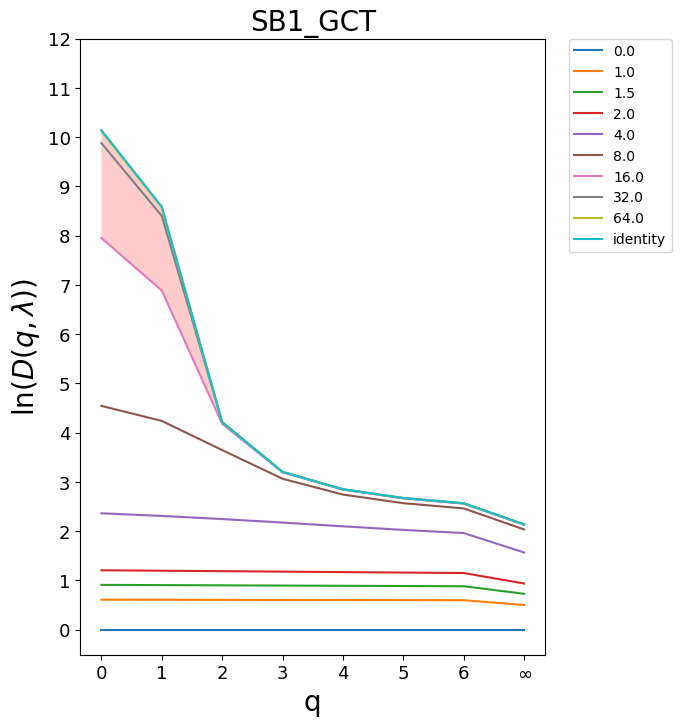

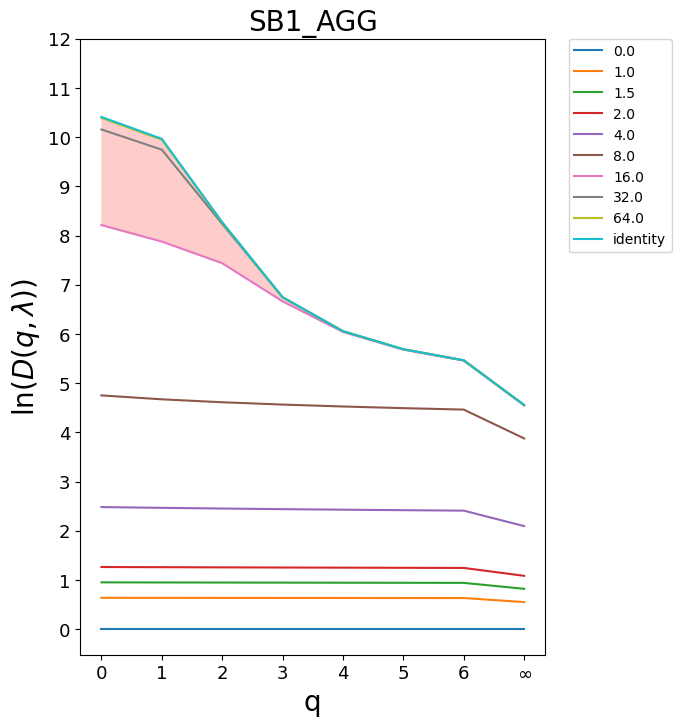

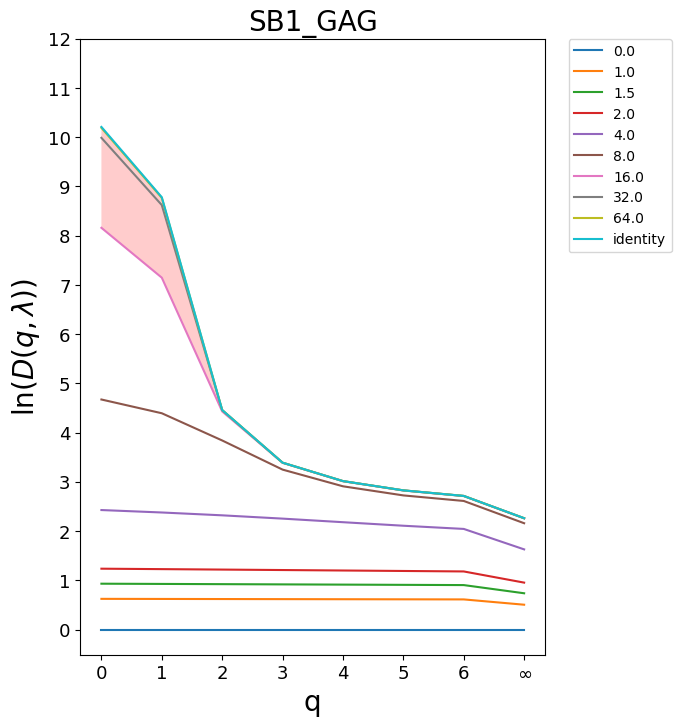

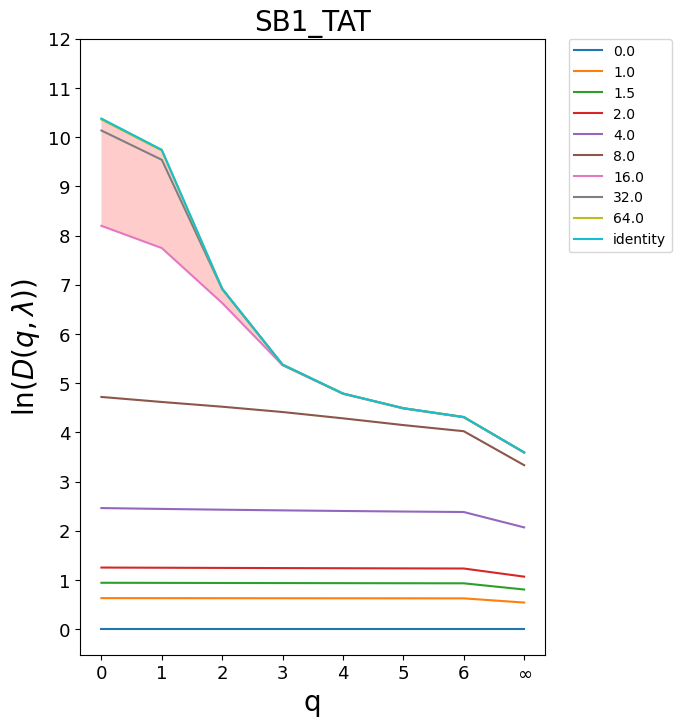

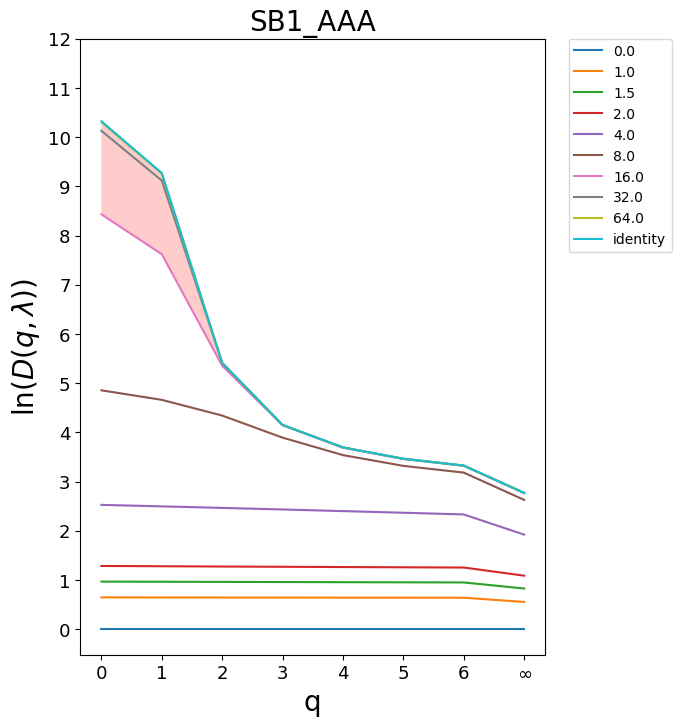

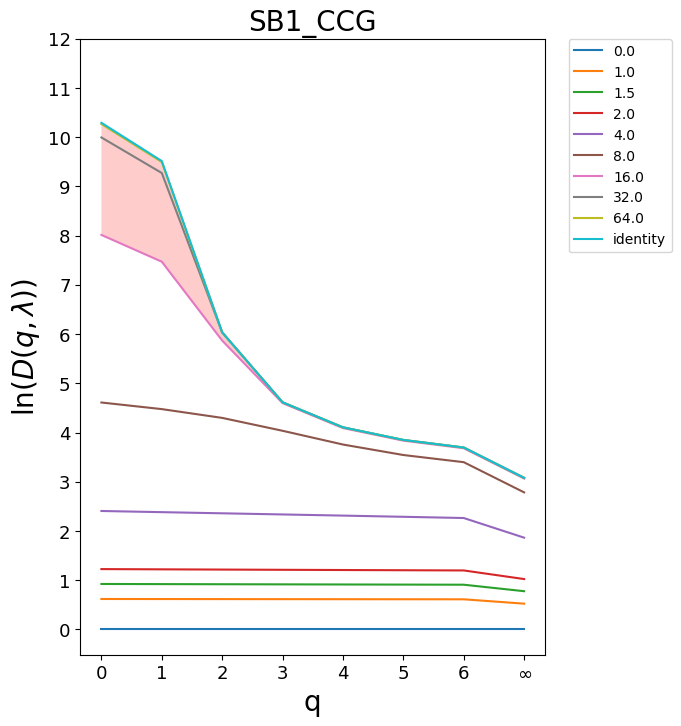

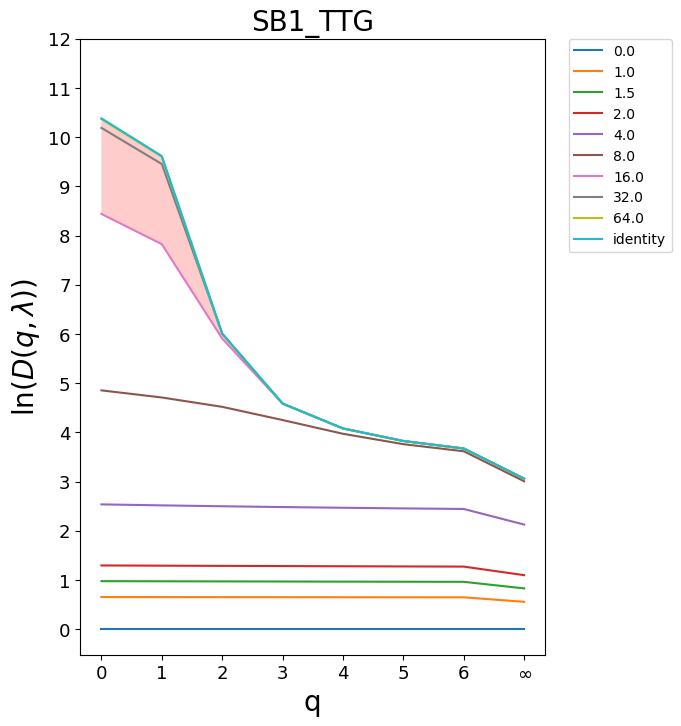

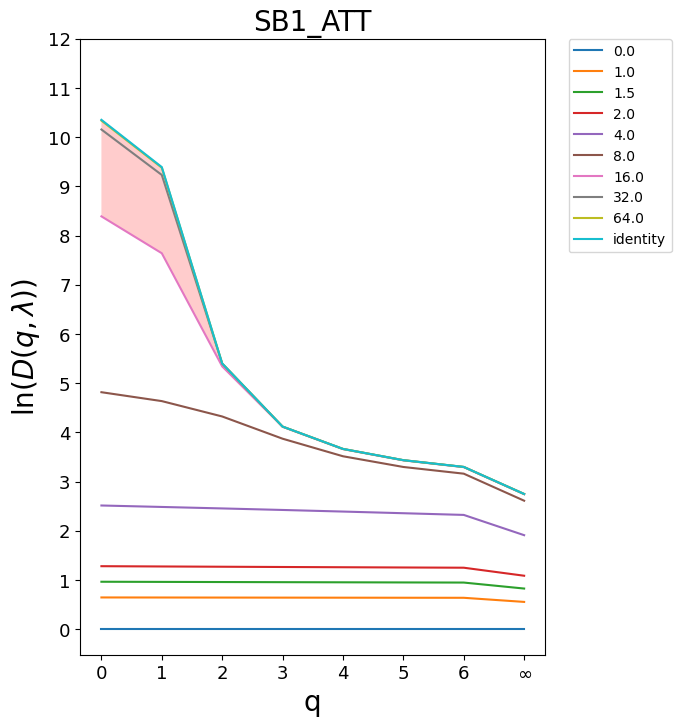

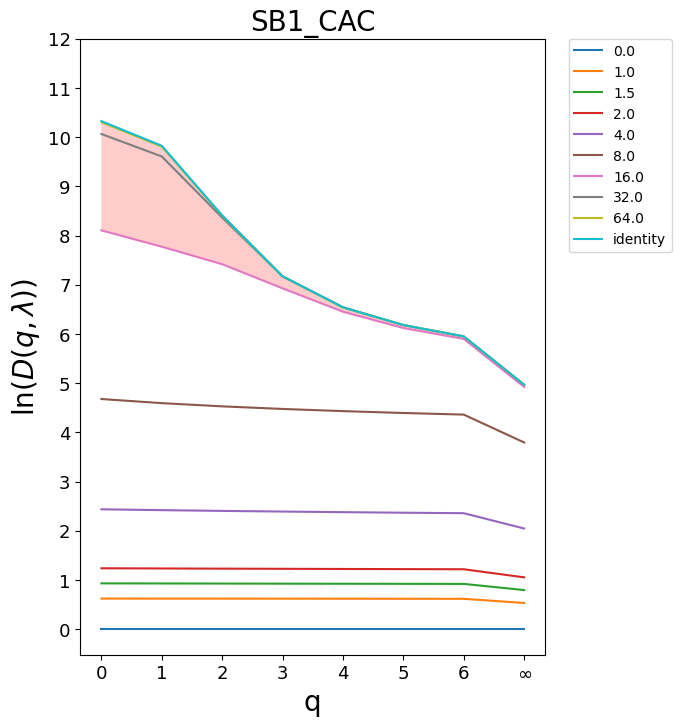

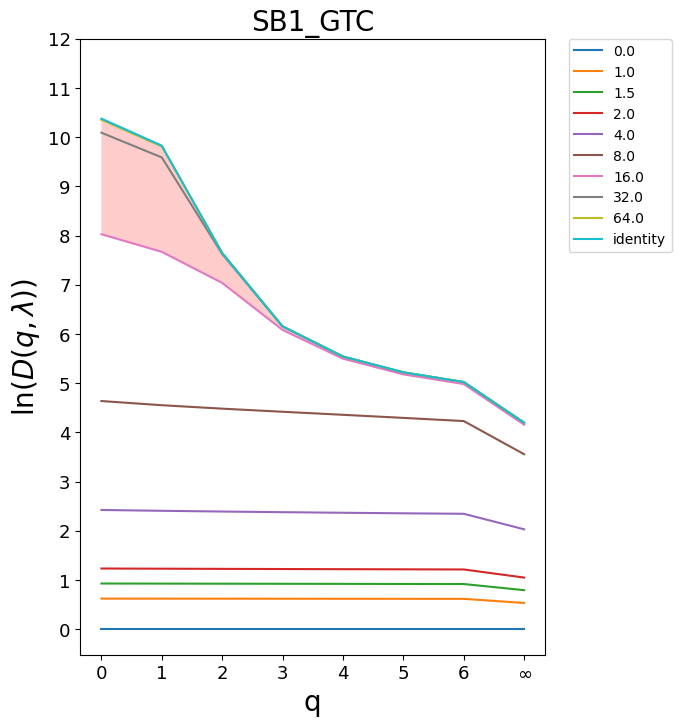

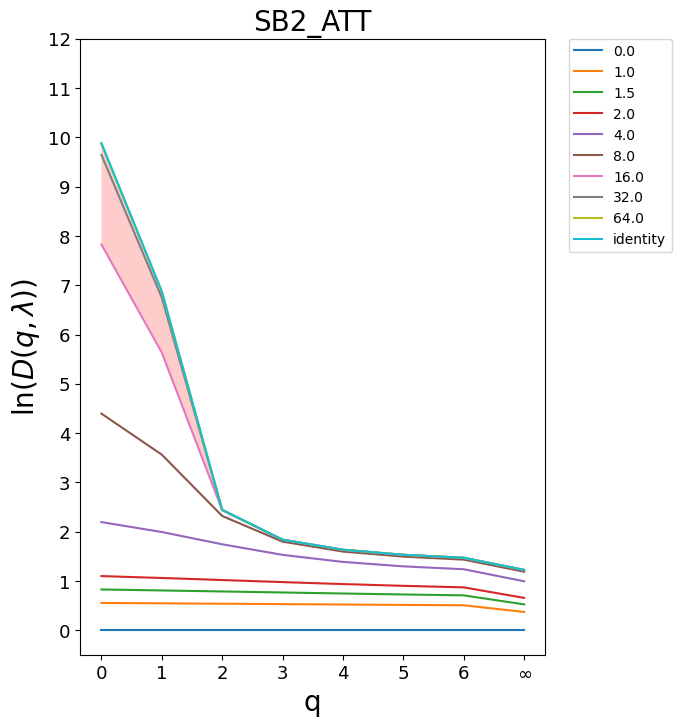

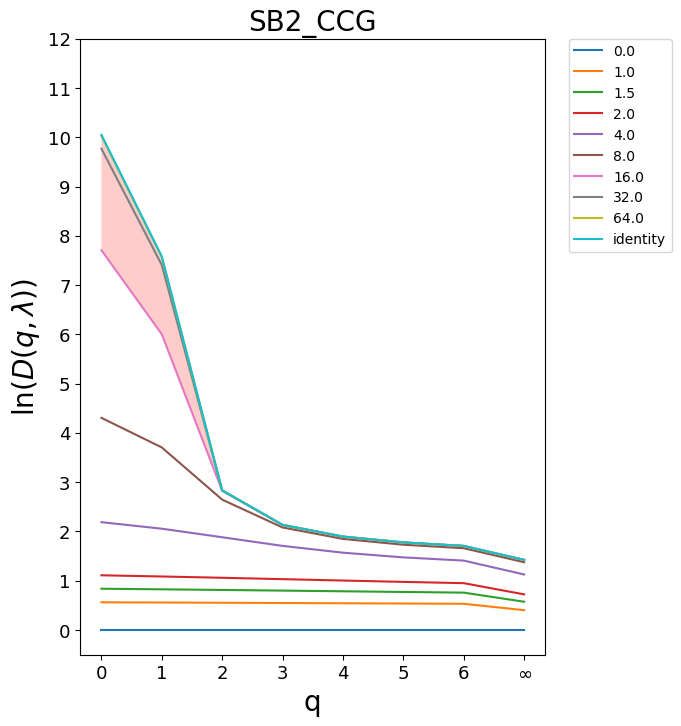

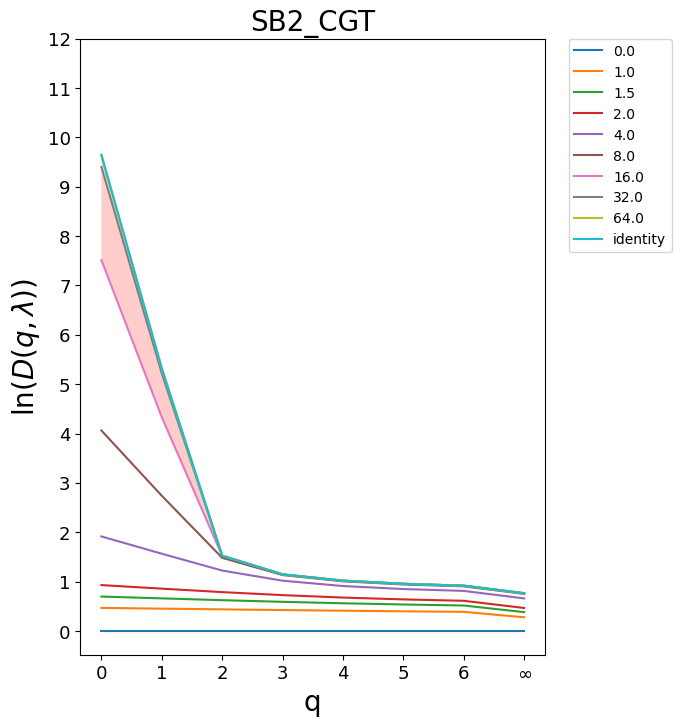

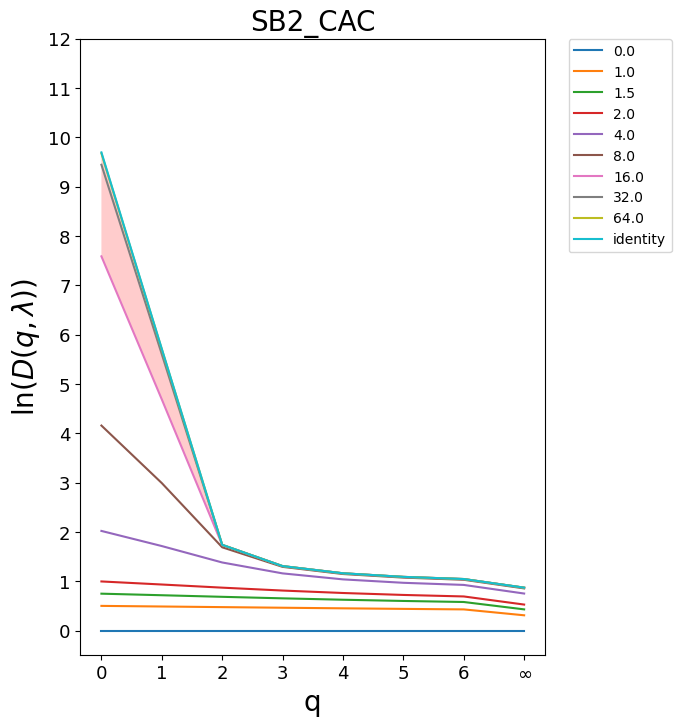

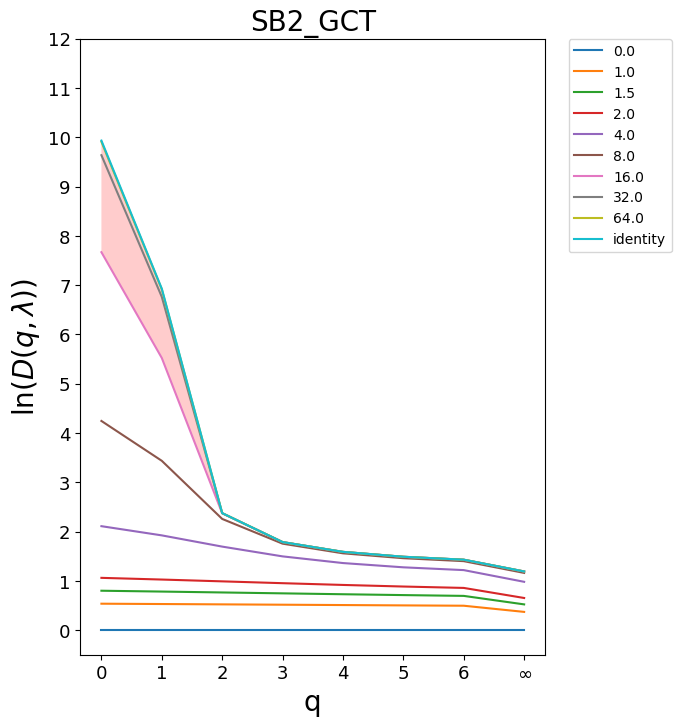

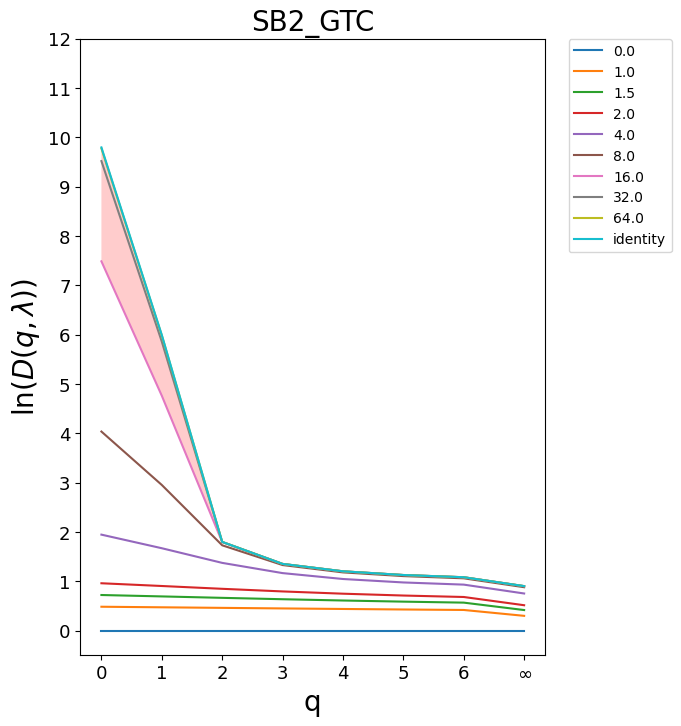

In [90]:
# define divP files 
divP_fpath = wdir_path + "divP_tsv/"
# Initiate empty list to store area dictionaries 
divP_areas = []
divP_slopes = []
average_delta_lambda = []
divP1_all_list = []
# iterate trough files 
for index,row in mddf.iterrows():
    # create pandas dataframes of divPs
    sample_name = row['sample_name'] 
    treatment = row['treatment']
    time = row['post_imm_time']
    divP_df = pd.read_csv(divP_fpath + row['sample_name'] + "_clean_cdr3_divP.tsv", comment='#', sep = '\t')
    divP_df = divP_df.set_index('q')
    divP_df.insert(0, '0.0', [1]*divP_df.shape[0])
    #ln transform the dataframe
    divP_df = np.log(divP_df)
    qs = divP_df.index.values[:-1]
    qs = np.append(qs, (divP_df.index.values[-2] + 1))
    divP_df["q"] = qs
    #calculate areas dictionary and append to a list
    divP_areas.append(calculate_area_between_curves(divP_df))
    #calculate slopes dictionary and append to a list
    divP_slopes.append(calculate_slopes(divP_df))
    ##calculate average delta lambda for small lambda: 
    average_delta_lambda.append(calculate_avg_delta_lambda_05_00(divP_df))
    #convert divP into a row df and append to a list: 
    divP1_all_list.append(make_divP_one_row_df(divP_df))
    #plot divPs
    divP_df = divP_df.drop(["0.1", "0.2", "0.25", "0.3", "0.4", "0.5", "0.75"], axis =1 )
    plt_divP(divP_df, sample_name, time, treatment, wdir_path)
    
divP_areas_df = pd.DataFrame.from_dict(divP_areas)
divP_slopes_df = pd.DataFrame.from_dict(divP_slopes)
average_delta_lambda_df = pd.DataFrame(average_delta_lambda, columns = ["Average area for small lambdas"])
divP1_all_df = pd.concat(divP1_all_list)
divP1_all_df = divP1_all_df.reset_index(drop = "True")
divP1_all_df = pd.concat([divP1_all_df, mddf], axis = 1)

divP_features = pd.concat([divP_areas_df, 
                           divP_slopes_df,
                           average_delta_lambda_df, 
                           mddf], axis=1)

In [91]:
divP_features = divP_features.rename(columns={"treatment": "Treatment", "post_imm_time": "Post-immunisation Time"})

In [92]:
divP_features["Post-immunisation Time"] = divP_features['Post-immunisation Time'].str.replace('d', '')
divP_features["Post-immunisation Time"] = divP_features["Post-immunisation Time"].astype(str).astype(int)
divP_features = divP_features.sort_values('Post-immunisation Time')
divP_features = divP_features.reset_index(drop = True)
divP_features





identity_64.0_area  identity_32.0_area  identity_16.0_area  \
0             0.044564            0.575735            5.366205   
1             0.049612            0.656132            6.310619   
2             0.051425            0.641020            5.482111   
3             0.053344            0.616943            4.661354   
4             0.054695            0.646004            4.970509   
5             0.039508            0.431304            2.740125   
6             0.060616            0.615198            4.316685   
7             0.018735            0.247261            2.449207   
8             0.029676            0.410933            4.162660   
9             0.031215            0.401233            4.623619   
10            0.020418            0.260011            2.808258   
11            0.020625            0.260989            2.866302   
12            0.031801            0.397808            3.420638   
13            0.019928            0.251584            2.679394   
14            0.022708            0.270835            2.698008   
15            0.029759            0.383435            4.142118   
16            0.029723            0.330584            2.873220   
17            0.022280            0.298423            2.766212   
18            0.025678            0.321831            2.998693   
19            0.025712            0.333345            3.409365   
20            0.026321            0.314896            2.547338   
21            0.019890            0.250281            2.287108   
22            0.021701            0.315776            2.770024   
23            0.018115            0.231505            2.066332   
24            0.018135            0.233357            2.081393   
25            0.020476            0.273722            2.393774   

    identity_8.0_area  identity_4.0_area  identity_2.0_area  \
0           21.165990          35.164010          43.002004   
1           22.950594          36.684369          44.388537   
2           20.754404          34.402128          42.064792   
3           17.973526          31.652673          39.399285   
4           18.331852          31.744368          39.427638   
5            7.312469          14.485585          20.898180   
6           16.339166          29.216480          36.703883   
7            8.742486          20.251040          28.357246   
8           16.269327          30.231149          38.230263   
9           20.702831          35.162584          43.218863   
10           9.337865          19.208162          27.096930   
11           9.750066          21.312120          29.622593   
12          11.299709          22.426400          30.122928   
13           9.185865          19.141805          27.075824   
14           8.274177          16.106237          23.098827   
15          18.035888          32.778502          40.994734   
16           8.226948          15.457240          22.123873   
17           7.599680          13.472260          19.336167   
18           9.697147          20.315483          28.215103   
19          12.579606          25.887550          34.010524   
20           6.589170          10.643226          14.671499   
21           6.349492          10.561494          14.699498   
22           7.154925          11.911961          16.640713   
23           5.486453           8.433268          11.103734   
24           5.604607           8.759475          11.776790   
25           6.090417           9.392395          12.481174   

    identity_1.5_area  identity_1.0_area  identity_0.75_area  \
0           45.037970          47.102523           48.145204   
1           46.391806          48.423911           49.450498   
2           44.057516          46.079329           47.100870   
3           41.416493          43.463684           44.498176   
4           41.432210          43.468199           44.497669   
5           22.729423          24.625395           25.594680   
6           38.663571          40.656326           41.664810   
7      

In [93]:
divP1_all_df = divP1_all_df.rename(columns={"treatment": "Treatment", "post_imm_time": "Post-immunisation Time"})
divP1_all_df["Post-immunisation Time"] = divP1_all_df['Post-immunisation Time'].str.replace('d', '')
divP1_all_df["Post-immunisation Time"] = divP1_all_df["Post-immunisation Time"].astype(str).astype(int)
divP1_all_df = divP1_all_df.sort_values('Post-immunisation Time')
divP1_all_df = divP1_all_df.reset_index(drop = True)
divP1_all_df


L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0   0.061487   0.06148  0.061474  0.061467  0.061461  0.061455  0.061448   
1   0.060581  0.060574  0.060566  0.060559  0.060552  0.060544  0.060537   
2   0.060332  0.060324  0.060317  0.060309  0.060302  0.060294  0.060287   
3   0.061066  0.061059  0.061052  0.061045  0.061039  0.061032  0.061025   
4   0.060892  0.060883  0.060873  0.060864  0.060854  0.060845  0.060835   
5   0.058304  0.058291  0.058278  0.058264  0.058251  0.058237  0.058224   
6   0.059804  0.059793  0.059782  0.059771  0.059761   0.05975  0.059739   
7   0.064595  0.064588   0.06458  0.064572  0.064565  0.064557  0.064549   
8   0.062592  0.062584  0.062576  0.062568   0.06256  0.062552  0.062543   
9   0.062908    0.0629  0.062891  0.062883  0.062875  0.062867  0.062859   
10  0.065091   0.06508  0.065069  0.065058  0.065046  0.065035  0.065024   
11  0.065782  0.065772  0.065762  0.065751  0.065741  0.065731  0.065721   
12  0.062209  0.062198  0.062188  0.062177  0.062167  0.062157  0.062146   
13  0.065343  0.065331   0.06532  0.065308  0.065296  0.065285  0.065273   
14  0.062937   0.06292  0.062904  0.062887   0.06287  0.062854  0.062837   
15  0.064034  0.064026  0.064018  0.064011  0.064003  0.063995  0.063987   
16  0.061671  0.061655  0.061639  0.061623  0.061607  0.061591  0.061576   
17  0.060717  0.060698  0.060678  0.060659   0.06064  0.060621  0.060601   
18  0.063407  0.063399   0.06339  0.063382  0.063374  0.063366  0.063358   
19  0.063563  0.063554  0.063546  0.063538   0.06353  0.063522  0.063514   
20  0.054753  0.054701  0.054649  0.054597  0.054545  0.054493  0.054441   
21  0.056369  0.056307  0.056246  0.056184  0.056122   0.05606  0.055998   
22  0.056934  0.056896  0.056858   0.05682  0.056782  0.056744  0.056705   
23  0.047466  0.047349  0.047232  0.047116     0.047  0.046885  0.046769   
24  0.051535  0.051439  0.051342  0.051246   0.05115  0.051053  0.050957   
25  0.049112  0.049021   0.04893  0.048838  0.048747  0.048656  0.048565   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_4 L_identity_q_5  \
0    0.052575  0.122868  0.122842  ...       6.412983       6.070457   
1    0.051832  0.121058  0.121029  ...        6.71513       6.402802   
2    0.051228   0.12056  0.120529  ...       6.225713       5.923223   
3    0.052254  0.122023  0.121995  ...       5.830811        5.53916   
4    0.051793  0.121682  0.121644  ...       5.786627       5.498708   
5    0.049584  0.116462  0.116408  ...       2.928516       2.754211   
6    0.050358  0.119503  0.119459  ...       5.461566       5.184441   
7    0.056379  0.129078  0.129047  ...       4.263005       4.055372   
8    0.053995  0.125091  0.125058  ...       5.541584       5.220811   
9    0.054136  0.125724   0.12569  ...       6.543145       6.182602   
10   0.056269  0.130082  0.130036  ...       3.664288       3.435642   
11   0.056344  0.131466  0.131426  ...       4.079247       3.824624   
12    0.05323   0.12432  0.124278  ...       4.105029        3.84884   
13   0.056347  0.130589  0.130542  ...       3.696211       3.465669   
14   0.052629  0.125762  0.125695  ...       3.015706       2.827485   
15   0.055507  0.127975  0.127943  ...       6.055319       5.688548   
16   0.052043   0.12321  0.123145  ...       2.852566       2.674665   
17   0.050643  0.121267  0.121188  ...       2.381074       2.232401   
18   0.054415  0.126706  0.126673  ...       3.898265       3.661105   
19   0.054813  0.127032  0.126999  ...       4.789254       4.490918   
20   0.041183  0.109285  0.109071  ...       1.590088       1.490714   
21   0.041227  0.112545  0.112292  ...       1.635042       1.532858   
22   0.043589  0.113693  0.113537  ...        1.89572       1.777246   
23    0.03197  0.094676  0.094195  ...       1.018719       0.955052   
24   0.036064  0.102789  0.102391  ...       1.165772       1.092916   
25   0.033798  0.098005   0.09763  ...       1.201407       1.126322   

   L_

In [94]:
divP_identity = divP1_all_df.copy()

In [95]:
divP_identity = divP_identity[[div for div in list(divP_identity) if "identity" in div] + ["Treatment", "Post-immunisation Time", "sample_name"]]

In [96]:
divP_identity["Treatment_Time"] = divP_identity.apply( lambda row: row["Treatment"] + 
                                                      "_day_" + str(row["Post-immunisation Time"]), axis = 1)



In [97]:
divP_identity_list = []
qDzs = [div for div in list(divP_identity) if div.startswith("L")]
for index, row in divP_identity.iterrows():
    for column in qDzs:
        divP_identity_list.append([row["sample_name"], int(column.split("_")[-1]), 
                                   row[column], 
                                   row["Treatment_Time"],row["Treatment"], 
                                   row["Post-immunisation Time"]])
        
        
        

In [98]:
divP_identity_plt_df = pd.DataFrame(divP_identity_list, columns = ["sample_name", "q", "qDZ",
                                                                   "Treatment_Time", "Treatment", 
                                                                   "Post-immunisation Time"])

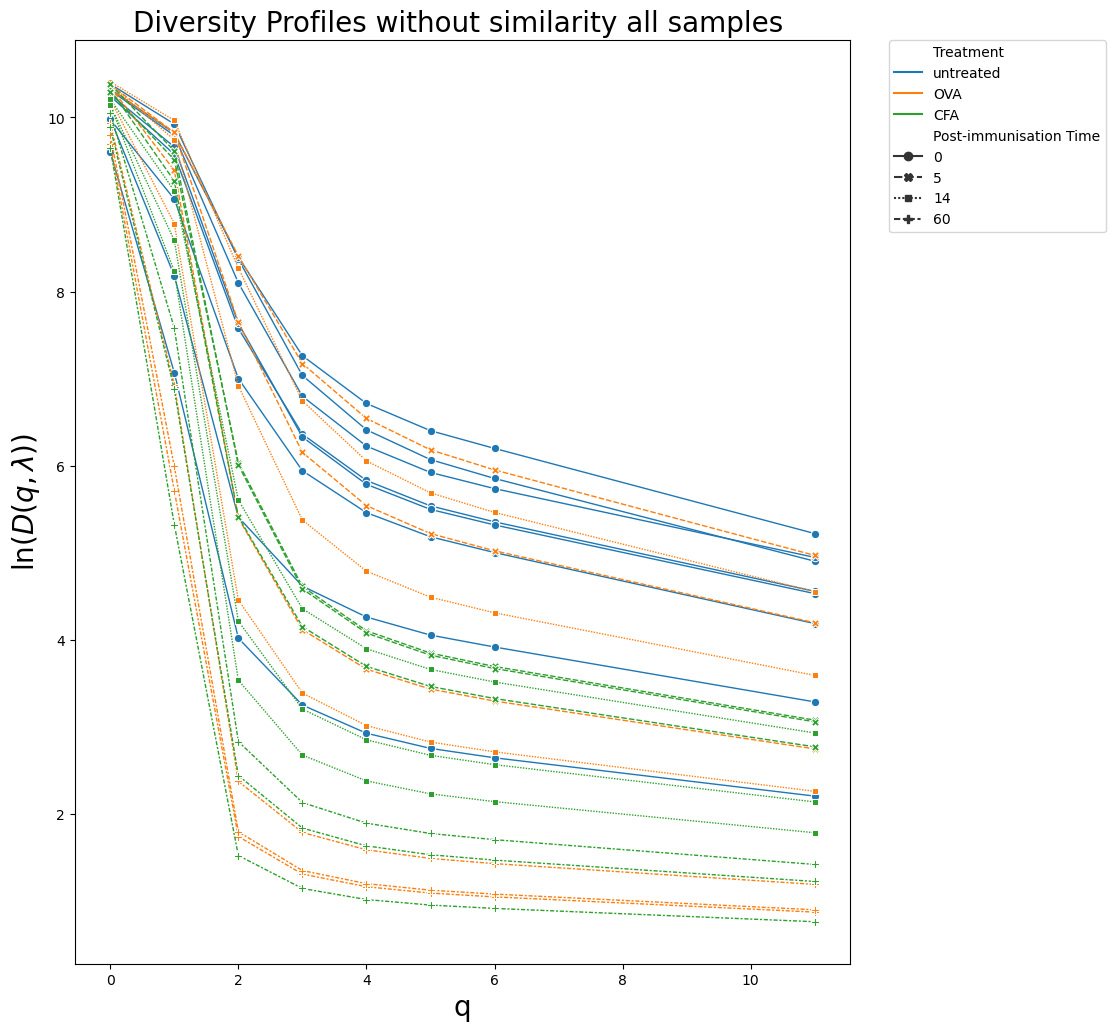

In [99]:
plt.figure(figsize=(10,12))
sns.color_palette("colorblind")
ax =sns.lineplot(data=divP_identity_plt_df, x="q", y="qDZ", hue="Treatment", style="Post-immunisation Time", units="sample_name", markers=True, estimator = None, lw=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.xlabel("q", fontsize = 20)
plt.ylabel("ln($D(q,\lambda)$)", fontsize = 20)
plt.title("Diversity Profiles without similarity all samples ", fontsize = 20)
plt.savefig(wdir_path + "Diversity_profiles_ID_all_samples.png", bbox_inches='tight')
plt.show()
plt.close()
    



## All samples
### important features corrplot

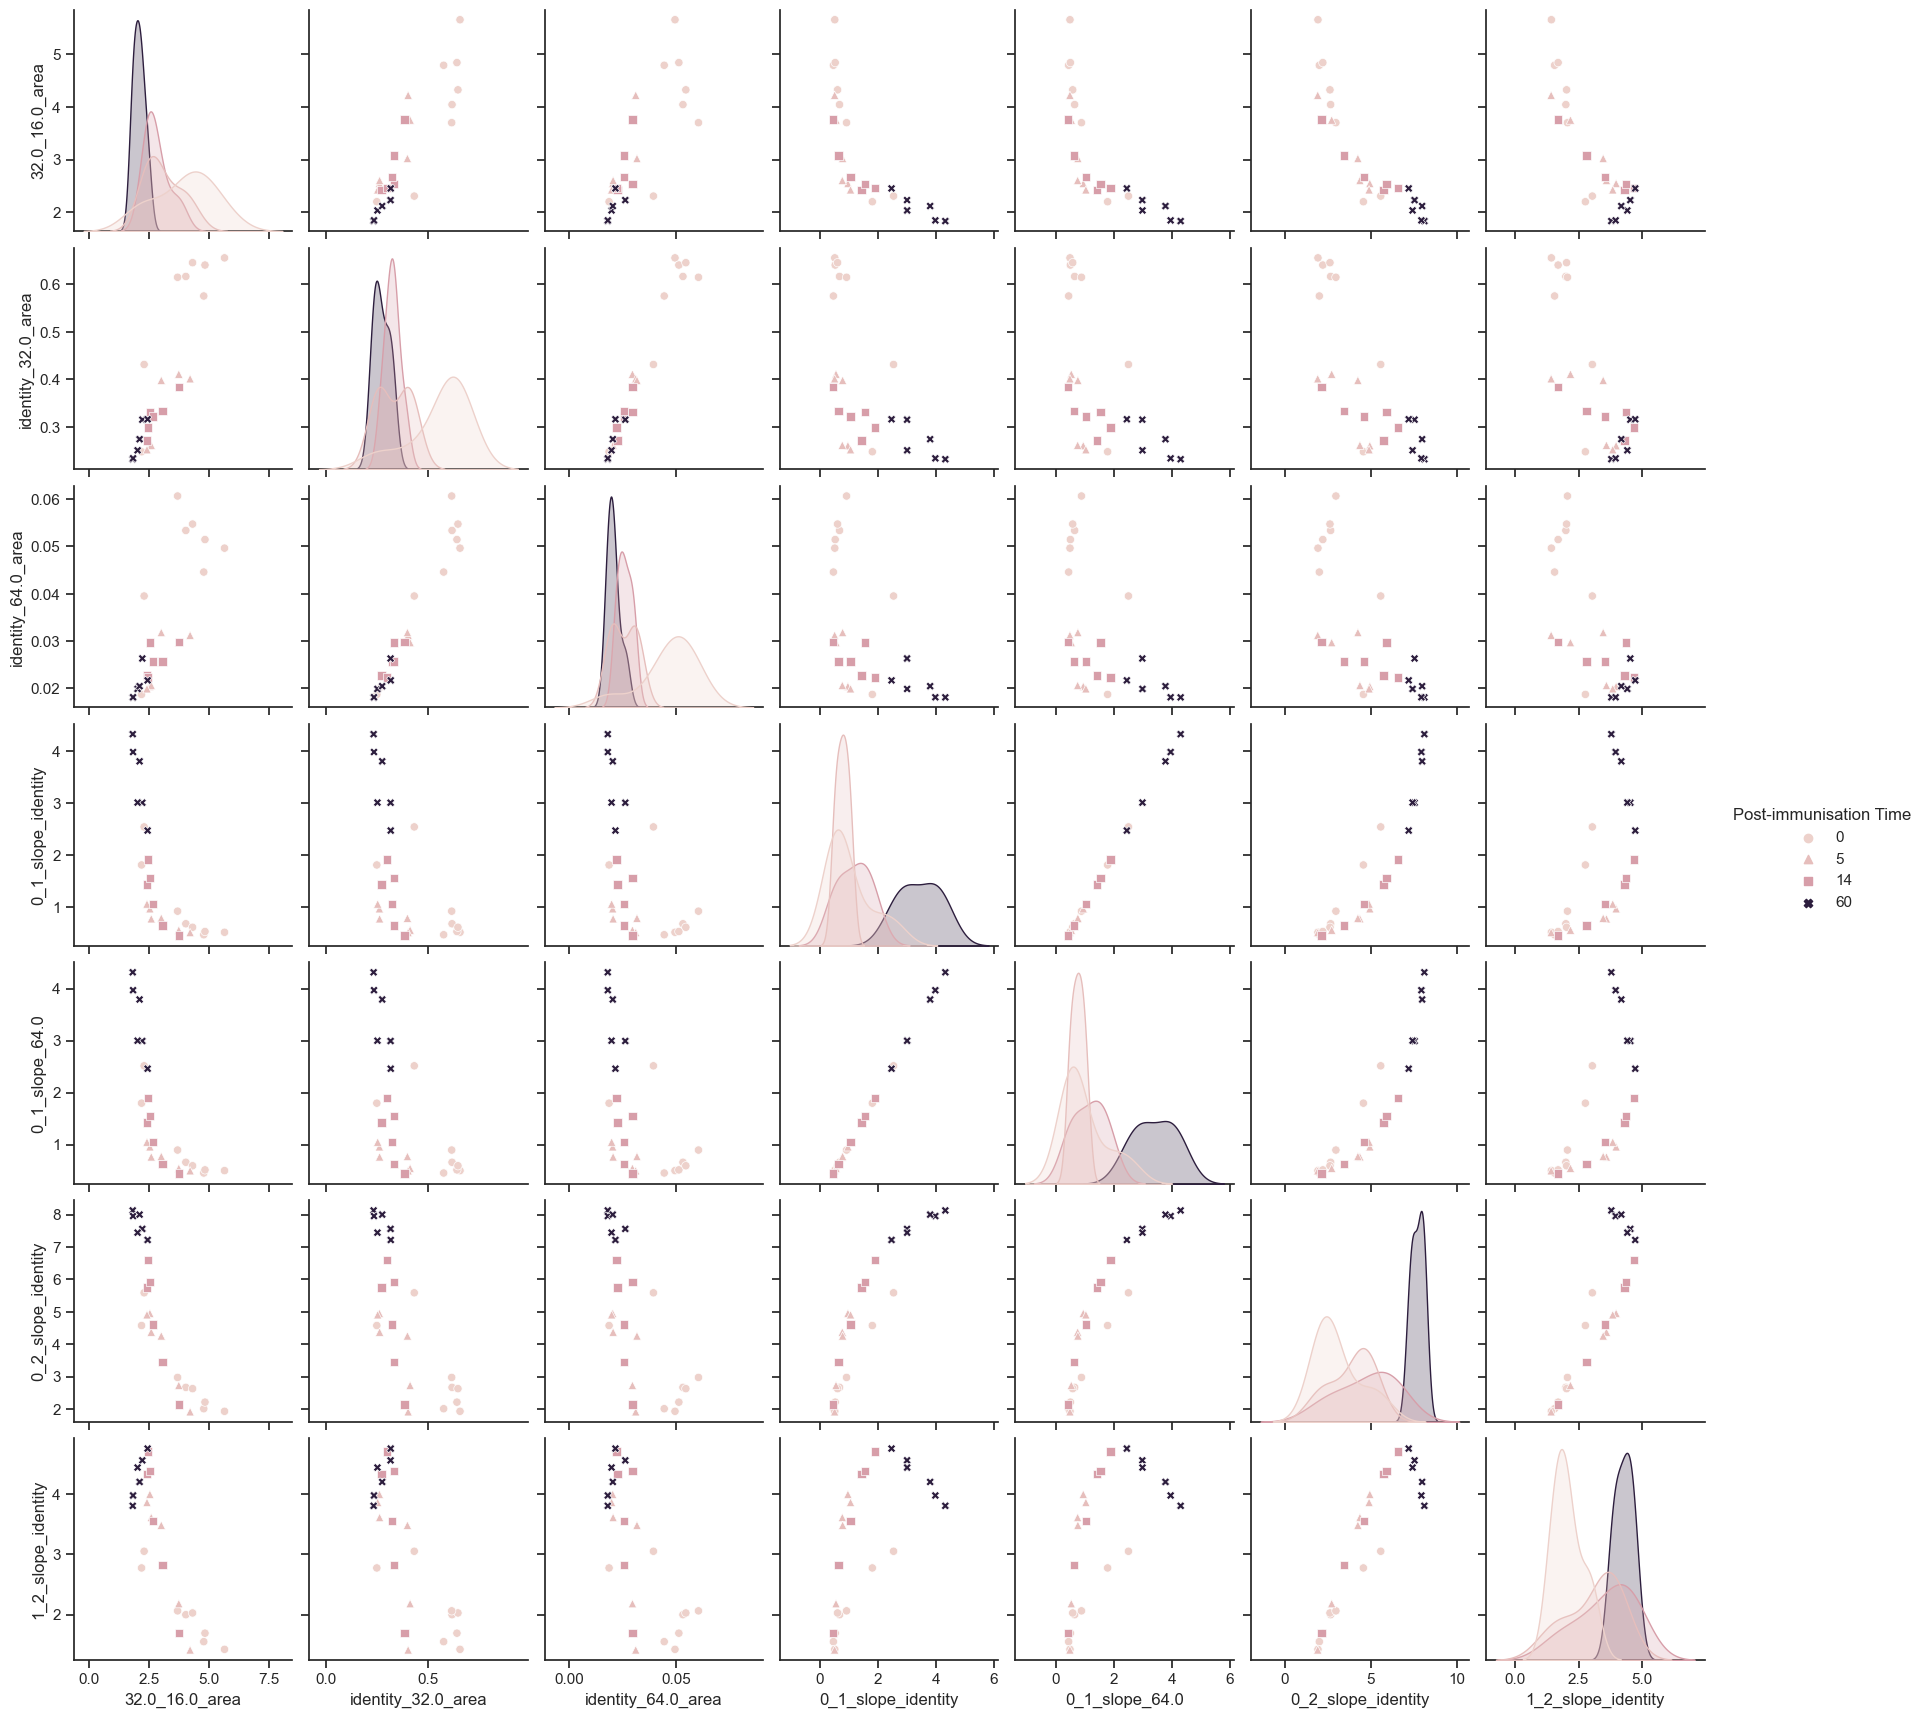

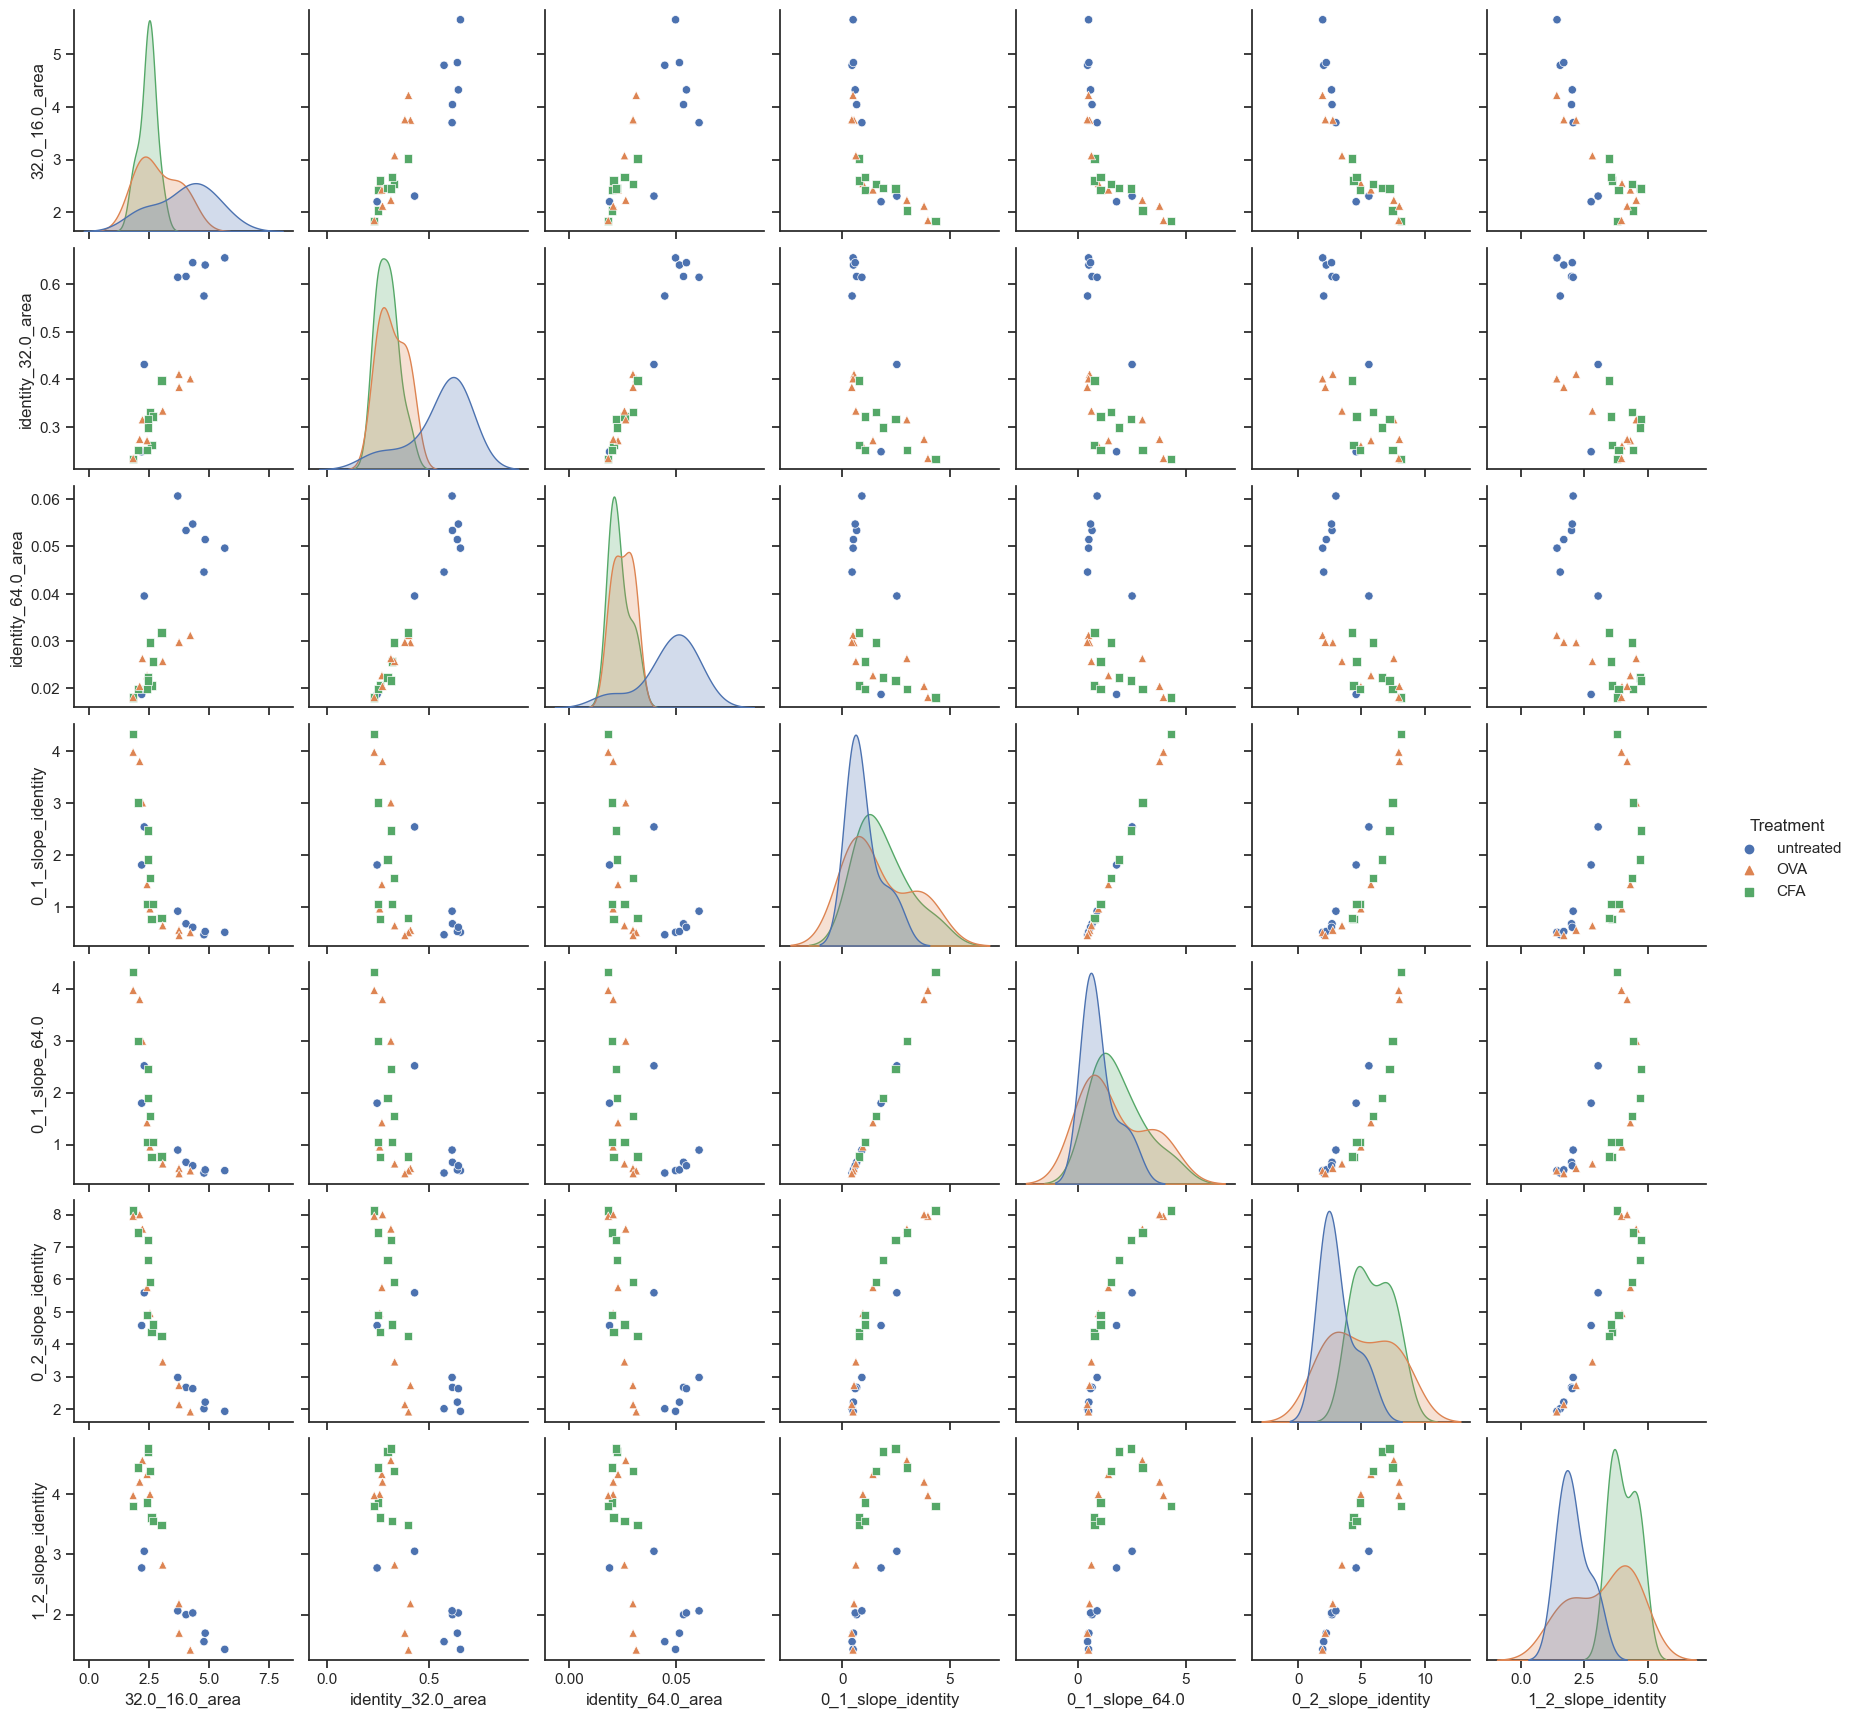

In [100]:
all_features = divP_features.copy()
important_ft = ["32.0_16.0_area", 
                "identity_32.0_area",
                "identity_64.0_area", 
                "0_1_slope_identity", 
                "0_1_slope_64.0", 
                "0_2_slope_identity", 
                "1_2_slope_identity",  
                "Treatment", 
               "Post-immunisation Time"]
divP_impr_ft = divP_features[important_ft]

sns.set(style="ticks")
sns.color_palette("colorblind")
pairplot = sns.pairplot(divP_impr_ft, hue="Post-immunisation Time", markers = ["o", "^", "s", "X"])
pairplot.savefig(wdir_path + "features_pairplot_timepoint.pdf")
pairplot

divP_impr_ft = divP_impr_ft.drop(['Post-immunisation Time'], axis=1)
sns.set(style="ticks")
sns.color_palette("colorblind")
pairplot = sns.pairplot(divP_impr_ft, hue="Treatment", markers = ["o", "^", "s"])
pairplot.savefig(wdir_path + "features_pairplot_treatment.pdf")
pairplot


### Selected features scatterplot 

In [101]:
def plot_selected_ft_scatterplot(ft1, ft2, hue_cat, style_cat, xlabel_f1, ylabel_ft2, wdir_path, divP_features_df, legend_opt = True):
    fig, ax = plt.subplots(figsize=(8,8))
    cmap = sns.color_palette("colorblind", len(list(set(divP_features_df[hue_cat]))))
    p = sns.scatterplot(x=ft1, y=ft2, 
                     data=divP_features_df,
                     hue=hue_cat, palette=cmap,  
                     style = style_cat, 
                     s = 140, legend = legend_opt
                     )
    if legend_opt:
        p.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(fontsize = 20, rotation=45)
    plt.yticks(fontsize = 20)
    plt.xlabel(xlabel_f1, fontsize = 26)
    plt.ylabel(ylabel_ft2, fontsize = 26)
    plt.tight_layout()
    if not os.path.isdir(wdir_path):
        os.makedirs(wdir_path, exist_ok=False)
    plt.savefig(wdir_path  + ft1 + "_" + ft2 + "_scatterplot_w_legend"+ str(legend_opt)+ ".pdf")
    plt.show()
    plt.close()


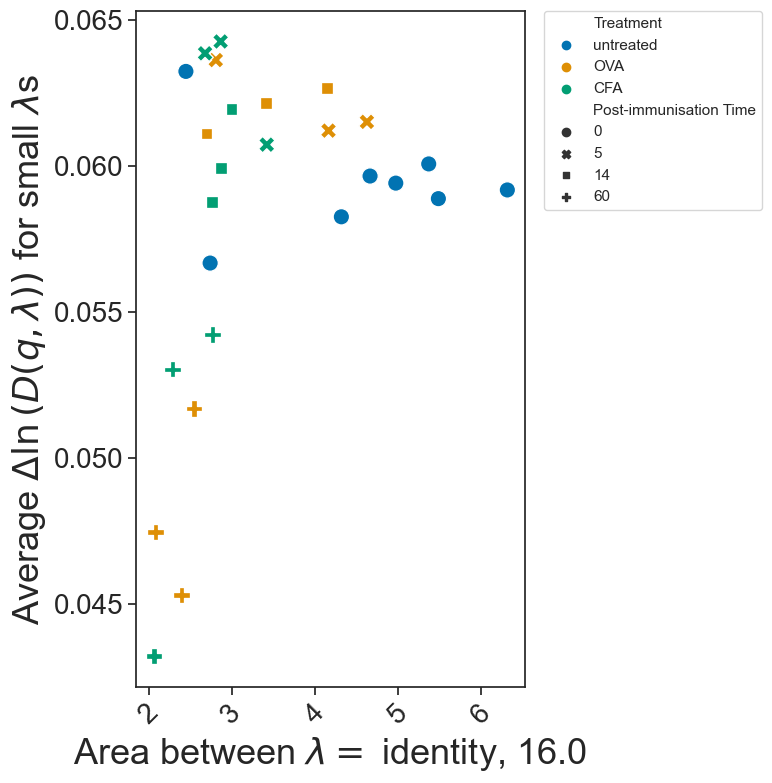

In [102]:
# delta lambda vs ID 16 area
plot_selected_ft_scatterplot( "identity_16.0_area","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 16.0 ","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, True)


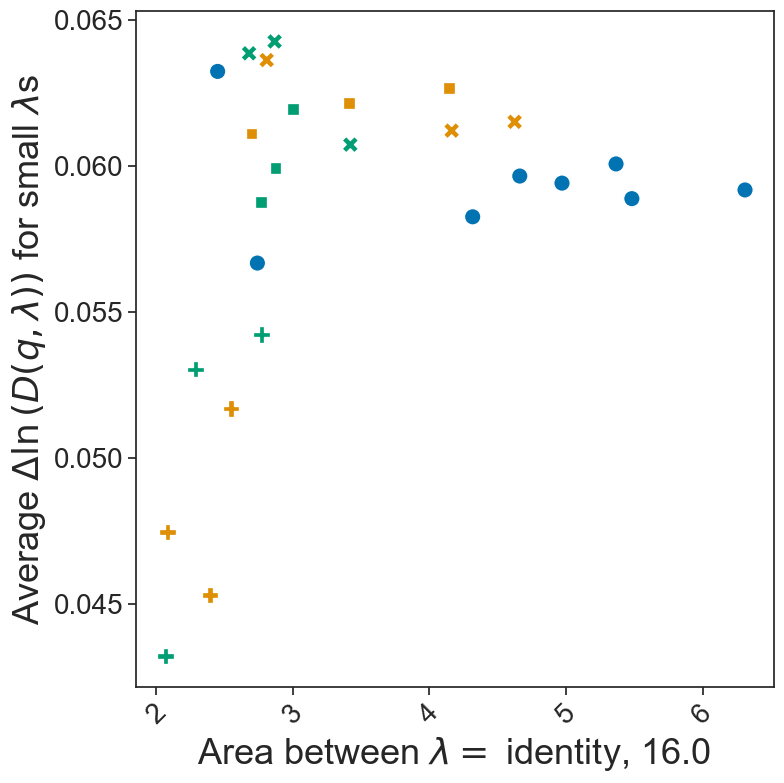

In [103]:
plot_selected_ft_scatterplot( "identity_16.0_area","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 16.0 ","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)


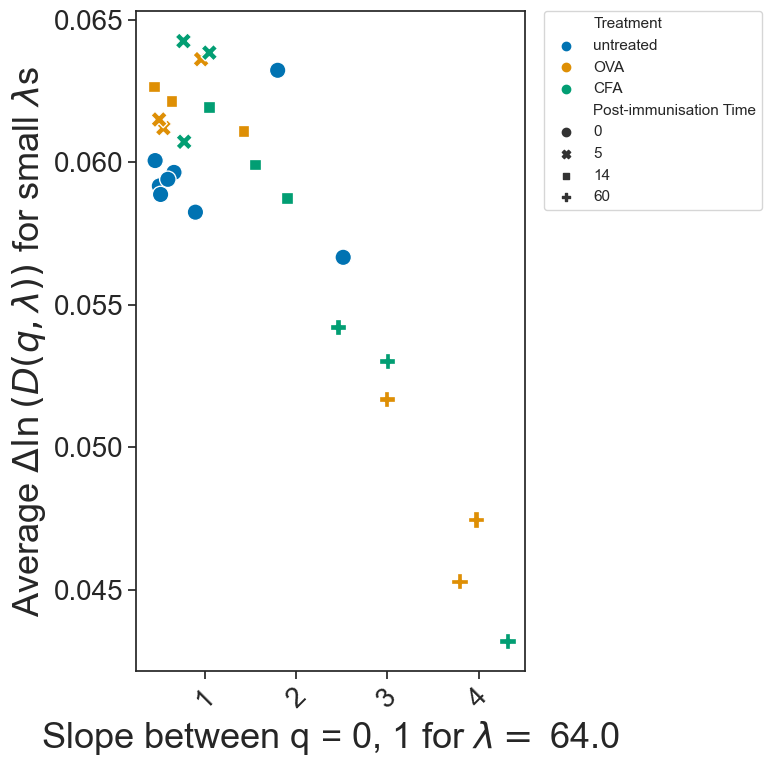

In [104]:
# delta lambda vs 0-1 slope 64

plot_selected_ft_scatterplot( "0_1_slope_64.0","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features)


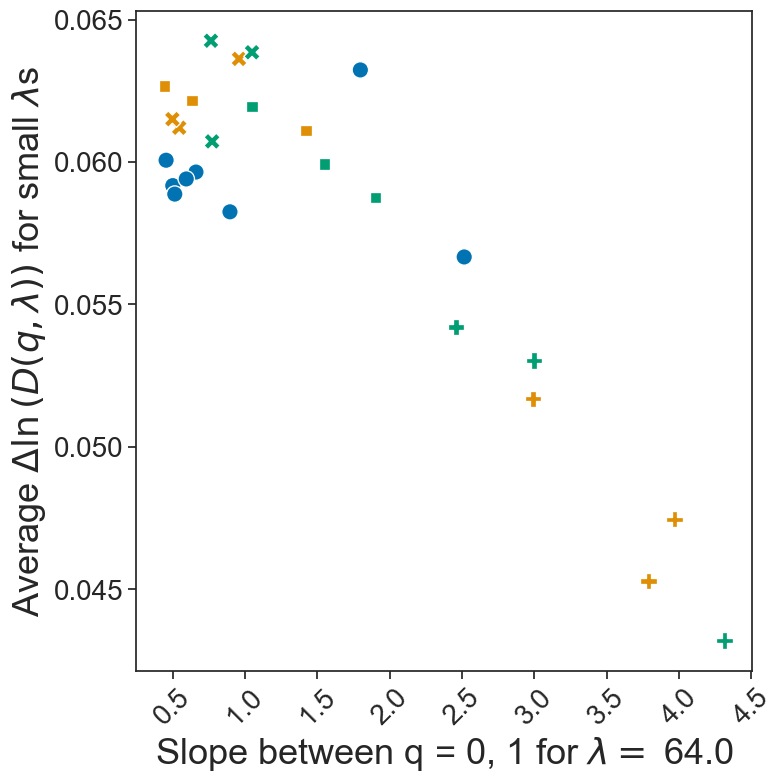

In [105]:
plot_selected_ft_scatterplot( "0_1_slope_64.0","Average area for small lambdas",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)


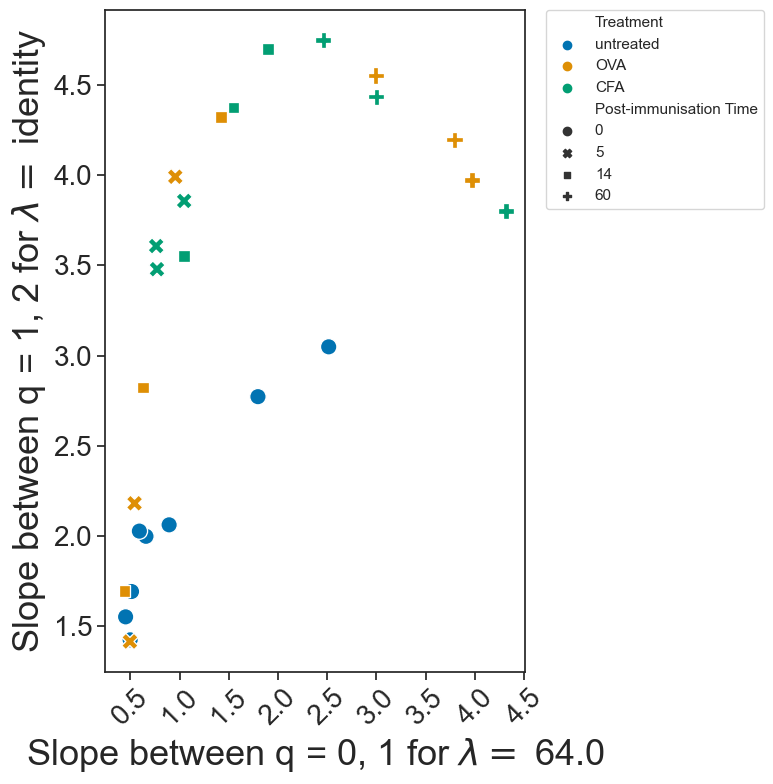

In [106]:
# 1-2 slope ID 0-1 slope 64

plot_selected_ft_scatterplot( "0_1_slope_64.0","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features)

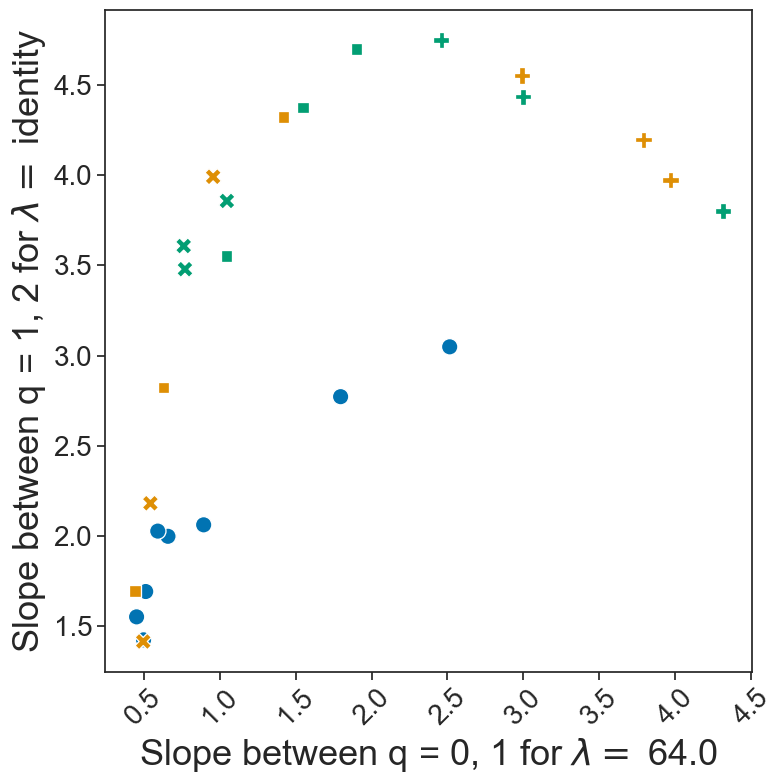

In [107]:
plot_selected_ft_scatterplot( "0_1_slope_64.0","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Slope between q = 0, 1 for $\lambda =$ 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)

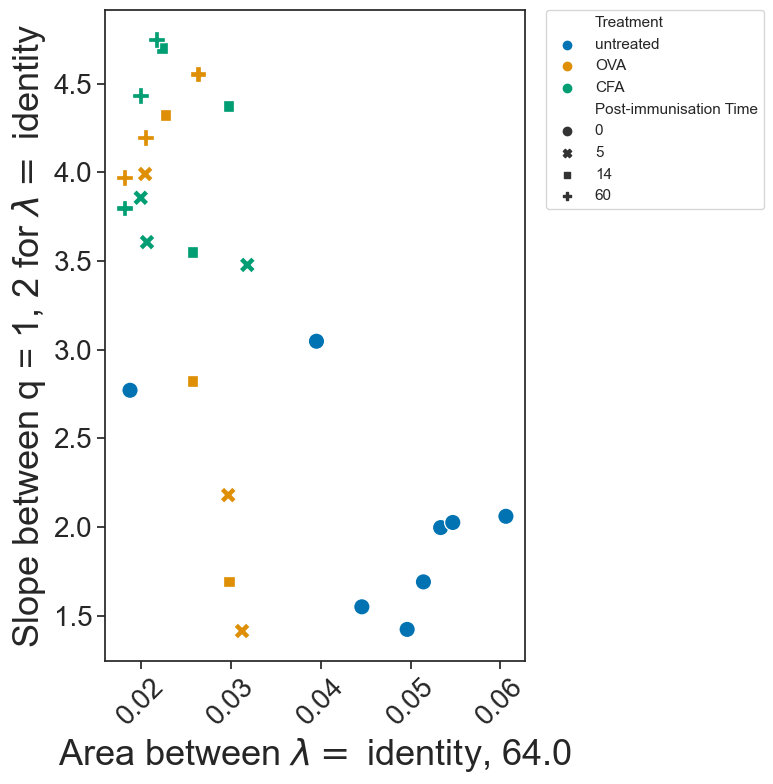

In [108]:
# 1-2 slope ID  ID 64 area

plot_selected_ft_scatterplot( "identity_64.0_area","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features)

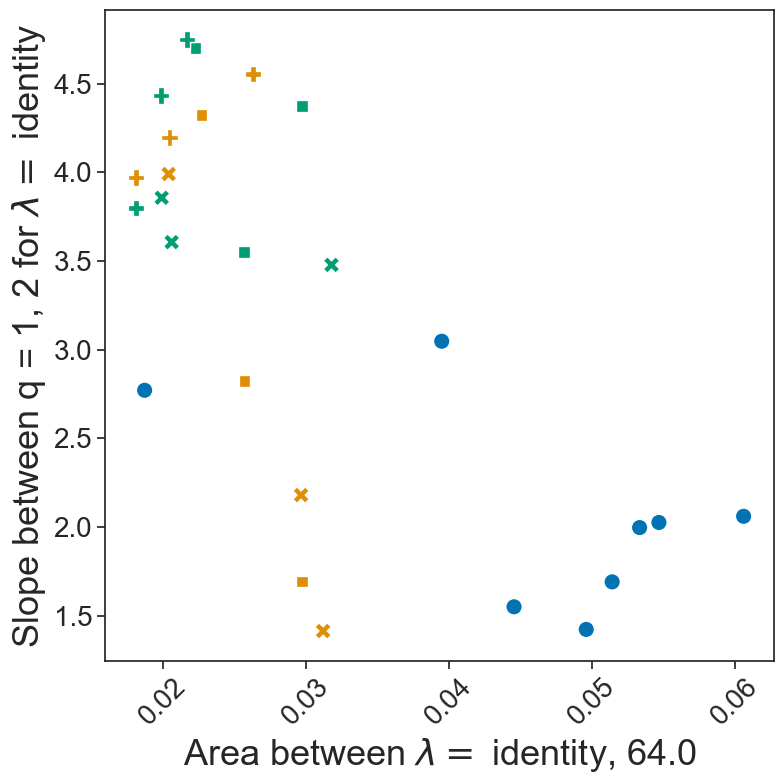

In [109]:
plot_selected_ft_scatterplot( "identity_64.0_area","1_2_slope_identity",
                    "Treatment", "Post-immunisation Time", 
                     "Area between $\lambda =$ identity, 64.0","Slope between q = 1, 2 for $\lambda =$ identity",
                    wdir_path + "Selected_features_scatterplot/", divP_features, False)

### Lineplot of areas and slope 


In [110]:
hm_ft_df =divP_features[["sample_name", "Treatment", "Post-immunisation Time" ,"Average area for small lambdas","identity_16.0_area","0_1_slope_identity"]]

hm_ft_df["sample_name"] = [" ".join([row["Treatment"], " ", str(row["Post-immunisation Time"]), " ", row["sample_name"]]) for index,row in hm_ft_df.iterrows()]
hm_ft_df["Regime"] = [" ".join([row["Treatment"], " Day ", str(row["Post-immunisation Time"])]) for index,row in hm_ft_df.iterrows()]
#hm_ft_df = hm_ft_df.set_index("sample_name")
hm_ft_df = hm_ft_df.sort_values(by=['Post-immunisation Time', "Treatment"])
hm_ft_df


/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50280/3406630853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_ft_df["sample_name"] = [" ".join([row["Treatment"], " ", str(row["Post-immunisation Time"]), " ", row["sample_name"]]) for index,row in hm_ft_df.iterrows()]
/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50280/3406630853.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_ft_df["Regime"] = [" ".join([row["Treatment"], " Day ", str(row["Post-immunisation Time"])]) 

sample_name  Treatment  Post-immunisation Time  \
0   untreated   0   CPX1A_GGA  untreated                       0   
1   untreated   0   CPX1A_TTG  untreated                       0   
2   untreated   0   CPX1B_CAC  untreated                       0   
3   untreated   0   EAE1A_GGA  untreated                       0   
4   untreated   0   EAE1A_TTG  untreated                       0   
5   untreated   0   EAE1B_CCG  untreated                       0   
6   untreated   0   EAE1B_TTG  untreated                       0   
7     untreated   0   SB1_TGC  untreated                       0   
11          CFA   5   SB1_TTG        CFA                       5   
12          CFA   5   SB1_CCG        CFA                       5   
13          CFA   5   SB1_AAA        CFA                       5   
8           OVA   5   SB1_GTC        OVA                       5   
9           OVA   5   SB1_CAC        OVA                       5   
10          OVA   5   SB1_ATT        OVA                       5   
16         CFA   14   SB1_GCT        CFA                      14   
17         CFA   14   SB1_CTA        CFA                      14   
18         CFA   14   SB1_ACC        CFA                      14   
14         OVA   14   SB1_GAG        OVA                      14   
15         OVA   14   SB1_AGG        OVA                      14   
19         OVA   14   SB1_TAT        OVA                      14   
21         CFA   60   SB2_ATT        CFA                      60   
22         CFA   60   SB2_CCG        CFA                      60   
23         CFA   60   SB2_CGT        CFA                      60   
20         OVA   60   SB2_GCT        OVA                      60   
24         OVA   60   SB2_CAC        OVA                      60   
25         OVA   60   SB2_GTC        OVA                      60   

    Average area for small lambdas  identity_16.0_area  0_1_slope_identity  \
0                         0.060064            5.366205            0.458929   
1                         0.059172            6.310619            0.506346   
2                         0.058875            5.482111            0.521180   
3                         0.059649            4.661354            0.670751   
4                         0.059406            4.970509            0.602844   
5                         0.056668            2.740125            2.538272   
6                         0.058253            4.316685            0.913521   
7                         0.063233            2.449207            1.804625   
11                        0.064258            2.866302            0.766652   
12                        0.060724            3.420638            0.777599   
13                        0.063852            2.679394            1.051514   
8                         0.061205            4.162660            0.548493   
9                         0.061505            4.623619            0.501338   
10                        0.063621            2.808258            0.960511   
16                        0.059923            2.873220            1.554332   
17                        0.058756            2.766212            1.907772   
18                        0.061944            2.998693            1.052432   
14                        0.061110            2.698008            1.427659   
15                        0.062669            4.142118            0.444642   
19                        0.062159            3.409365            0.634549   
21                        0.053031            2.287108            3.007367   
22                        0.054217            2.770024            2.468219   
23                        0.043204            2.066332            4.326891   
20                        0.051692            2.547338            3.004399   
24                        0.047461            2.081393            3.981984   
25                        0.045298            2.393774            3.802963   

               Regime  
0   untreated  Day  0  
1   untreated  Day  0  
2 

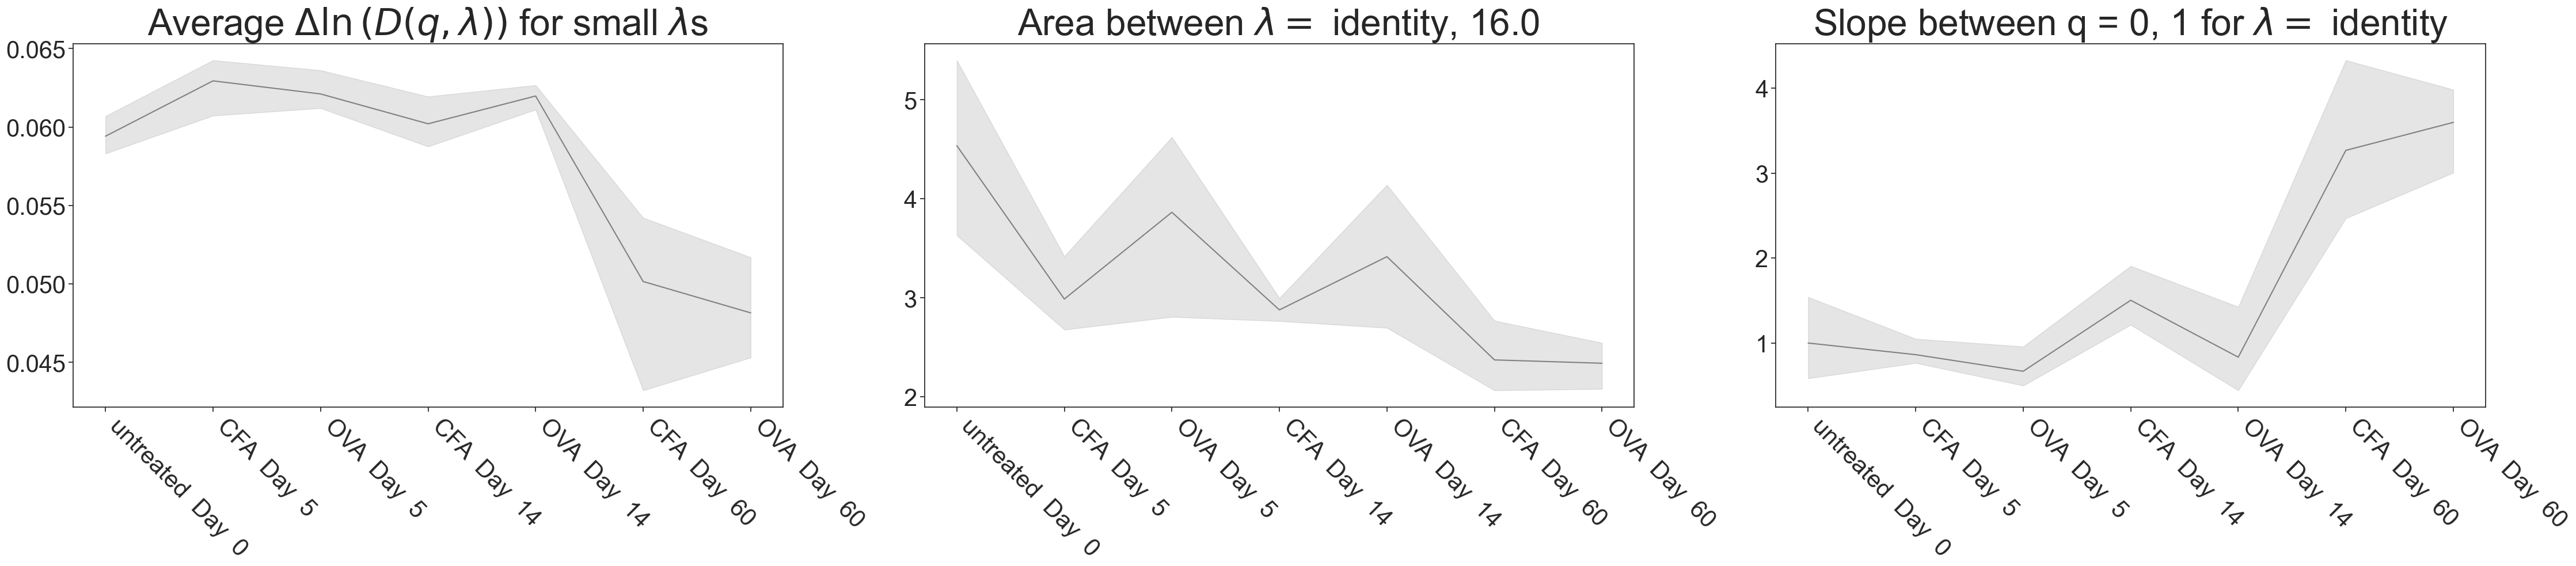

In [111]:
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=30)
plt.rc('axes', labelsize=46) 

fig, ax = plt.subplots(1, 3, figsize=(45, 10), sharey=False, sharex = True)
p1 = sns.lineplot(x="Regime", y="Average area for small lambdas", data=hm_ft_df, sort=False, ax=ax[0], color = "gray")
p2 = sns.lineplot(x="Regime", y="identity_16.0_area", data=hm_ft_df, sort=False, ax=ax[1], color = "gray")
p3 = sns.lineplot(x="Regime", y="0_1_slope_identity", data=hm_ft_df, sort=False, ax=ax[2], color = "gray")

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

p1.set_title('Average $\Delta \ln{(D(q,\lambda))}$ for small $\lambda$s', fontsize = 46)
p2.set_title('Area between $\lambda =$ identity, 16.0 ', fontsize = 46)
p3.set_title('Slope between q = 0, 1 for $\lambda =$ identity', fontsize = 46)

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=-45, ha="left")
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=-45, ha="left")
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=-45, ha="left")

plt.tight_layout()

plt.savefig(wdir_path + "lineplot_areas_slope.pdf")

### PCA on features 

In [112]:
post_imm_time_df = divP_features["Post-immunisation Time"]
treatment_df = divP_features["Treatment"]
sample_names_df = divP_features["sample_name"]

In [113]:
divP_features_treatment_time = divP_features.drop(["sample_name", 
                                                               "library", 
                                                               "sample_type", 
                                                               "unique_CDR3s"], axis=1)

divP_features_treatment_time

identity_64.0_area  identity_32.0_area  identity_16.0_area  \
0             0.044564            0.575735            5.366205   
1             0.049612            0.656132            6.310619   
2             0.051425            0.641020            5.482111   
3             0.053344            0.616943            4.661354   
4             0.054695            0.646004            4.970509   
5             0.039508            0.431304            2.740125   
6             0.060616            0.615198            4.316685   
7             0.018735            0.247261            2.449207   
8             0.029676            0.410933            4.162660   
9             0.031215            0.401233            4.623619   
10            0.020418            0.260011            2.808258   
11            0.020625            0.260989            2.866302   
12            0.031801            0.397808            3.420638   
13            0.019928            0.251584            2.679394   
14            0.022708            0.270835            2.698008   
15            0.029759            0.383435            4.142118   
16            0.029723            0.330584            2.873220   
17            0.022280            0.298423            2.766212   
18            0.025678            0.321831            2.998693   
19            0.025712            0.333345            3.409365   
20            0.026321            0.314896            2.547338   
21            0.019890            0.250281            2.287108   
22            0.021701            0.315776            2.770024   
23            0.018115            0.231505            2.066332   
24            0.018135            0.233357            2.081393   
25            0.020476            0.273722            2.393774   

    identity_8.0_area  identity_4.0_area  identity_2.0_area  \
0           21.165990          35.164010          43.002004   
1           22.950594          36.684369          44.388537   
2           20.754404          34.402128          42.064792   
3           17.973526          31.652673          39.399285   
4           18.331852          31.744368          39.427638   
5            7.312469          14.485585          20.898180   
6           16.339166          29.216480          36.703883   
7            8.742486          20.251040          28.357246   
8           16.269327          30.231149          38.230263   
9           20.702831          35.162584          43.218863   
10           9.337865          19.208162          27.096930   
11           9.750066          21.312120          29.622593   
12          11.299709          22.426400          30.122928   
13           9.185865          19.141805          27.075824   
14           8.274177          16.106237          23.098827   
15          18.035888          32.778502          40.994734   
16           8.226948          15.457240          22.123873   
17           7.599680          13.472260          19.336167   
18           9.697147          20.315483          28.215103   
19          12.579606          25.887550          34.010524   
20           6.589170          10.643226          14.671499   
21           6.349492          10.561494          14.699498   
22           7.154925          11.911961          16.640713   
23           5.486453           8.433268          11.103734   
24           5.604607           8.759475          11.776790   
25           6.090417           9.392395          12.481174   

    identity_1.5_area  identity_1.0_area  identity_0.75_area  \
0           45.037970          47.102523           48.145204   
1           46.391806          48.423911           49.450498   
2           44.057516          46.079329           47.100870   
3           41.416493          43.463684           44.498176   
4           41.432210          43.468199           44.497669   
5           22.729423          24.625395           25.594680   
6           38.663571          40.656326           41.664810   
7      

In [114]:
divP_features_treatment_time.shape

(26, 187)

In [115]:
observables = [col for col in list(divP_features_treatment_time) if col != "Treatment"]
observables = [obs for obs in observables if obs != "Post-immunisation Time"]
# Separating out the features
x = divP_features_treatment_time.loc[:, observables].values
# Separating out the target
y = divP_features_treatment_time.loc[:,'Treatment'].values

In [116]:
x.shape

(26, 185)

In [117]:
x.mean(), x.std()

(11.592459018234026, 14.534670365282224)

In [118]:
x_scaled = StandardScaler().fit_transform(x)

In [119]:
x_scaled.mean(), x_scaled.std()

(6.130462273190054e-17, 1.0)

In [120]:
pca_scaled = decomposition.PCA(n_components=26)
principalComponents_scaled = pca_scaled.fit_transform(x_scaled)

principalDf_scaled = pd.DataFrame(data = principalComponents_scaled)
principalDf_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_scaled)]
finalDf_scaled = pd.concat([principalDf_scaled, divP_features_treatment_time[["Treatment", "Post-immunisation Time"]]], axis = 1)



In [121]:
def plotPCA(pca_scaled, colour_category, style_category, final_Df, wdir_path, fig_name, legend):
    """
    INPUT:  pca_scaled: pca object
            colour_category: string denoting a categorical var to colour by
            style_category: string denoting a categorical var for the point shape 
            final_Df: DataFrame with principal components and categorical variables
            wdir_path: path to working directory
            fig_name: string for figure name, ending with the extension pdf or png
            legend: True or False
            
    OUTPUT: 
            PCA figure with the aspect ratio corresponding to the principal components values 
    """
    per_PC1 = int(round(pca_scaled.explained_variance_ratio_[0]*100, 0))
    per_PC2 = int(round(pca_scaled.explained_variance_ratio_[1]*100, 0))
    if per_PC1 != 0 and per_PC2 != 0:
        fig, ax = plt.subplots(figsize=(per_PC1/5,per_PC2/5))
    else: 
        fig, ax = plt.subplots(figsize=(20,1))
    cmap = sns.color_palette("colorblind", len(list(set(final_Df[colour_category]))))
    if legend == True: 
        legend_box = "full"
    else: 
        legend_box = False
    p = sns.scatterplot(x="PC_0", y="PC_1",
                     hue=colour_category, style = style_category,
                     palette=cmap, s=100,
                     data=final_Df, 
                     alpha = 1, legend = legend_box)
    if legend == True: 
        p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tick_params(axis='both',          # changes apply which axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    left = False,
                    right = False,
                    labelbottom=False,
                    labelleft = False) # labels along the bottom edge are off
    #plt.xticks(fontsize = 13)
    #plt.yticks(fontsize = 13)
    plt.xlabel("".join(["PC1 (",str(per_PC1),"%)"]), fontsize = 15)
    plt.ylabel("".join(["PC2 (",str(per_PC2),"%)"]), fontsize = 15)
    plt.tight_layout()
    plt.savefig(wdir_path + fig_name, bbox_inches='tight')

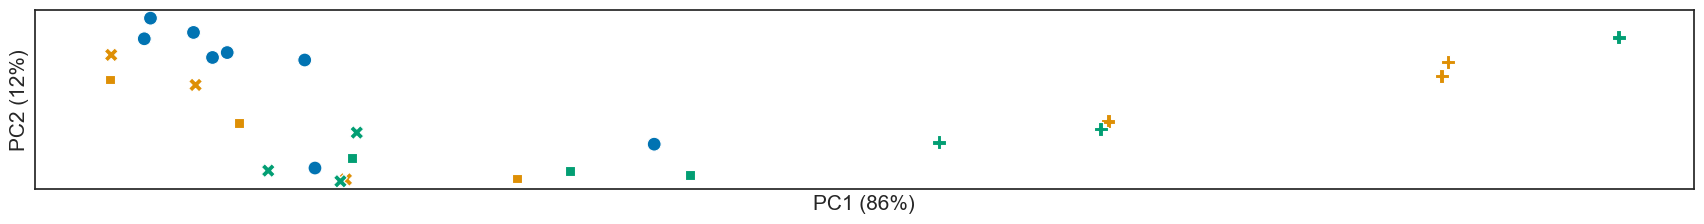

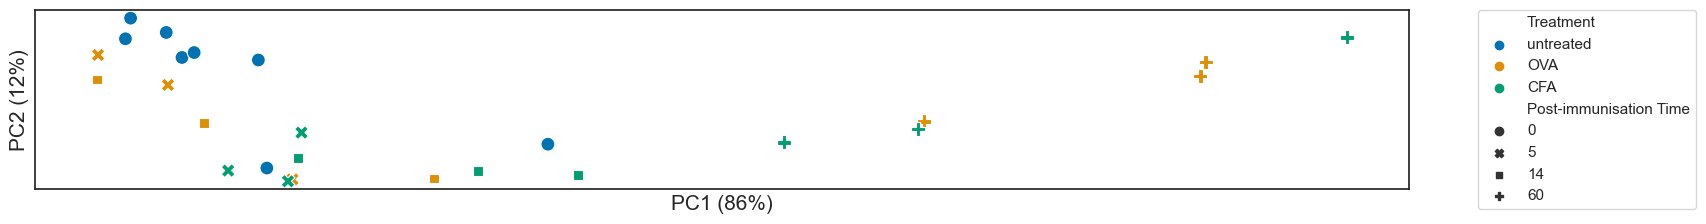

In [122]:
plotPCA(pca_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_scaled, wdir_path, "PCA_features.pdf", False)


plotPCA(pca_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_scaled, wdir_path, "PCA_features_w_legend.pdf", True)




### PCA on $D(q,\lambda)$

In [123]:
# remove PBS
divP1_all_df = divP1_all_df[divP1_all_df.Treatment != "PBS"]
divP1_all_df = divP1_all_df.reset_index(drop = "True")
divP1_all_df

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0   0.061487   0.06148  0.061474  0.061467  0.061461  0.061455  0.061448   
1   0.060581  0.060574  0.060566  0.060559  0.060552  0.060544  0.060537   
2   0.060332  0.060324  0.060317  0.060309  0.060302  0.060294  0.060287   
3   0.061066  0.061059  0.061052  0.061045  0.061039  0.061032  0.061025   
4   0.060892  0.060883  0.060873  0.060864  0.060854  0.060845  0.060835   
5   0.058304  0.058291  0.058278  0.058264  0.058251  0.058237  0.058224   
6   0.059804  0.059793  0.059782  0.059771  0.059761   0.05975  0.059739   
7   0.064595  0.064588   0.06458  0.064572  0.064565  0.064557  0.064549   
8   0.062592  0.062584  0.062576  0.062568   0.06256  0.062552  0.062543   
9   0.062908    0.0629  0.062891  0.062883  0.062875  0.062867  0.062859   
10  0.065091   0.06508  0.065069  0.065058  0.065046  0.065035  0.065024   
11  0.065782  0.065772  0.065762  0.065751  0.065741  0.065731  0.065721   
12  0.062209  0.062198  0.062188  0.062177  0.062167  0.062157  0.062146   
13  0.065343  0.065331   0.06532  0.065308  0.065296  0.065285  0.065273   
14  0.062937   0.06292  0.062904  0.062887   0.06287  0.062854  0.062837   
15  0.064034  0.064026  0.064018  0.064011  0.064003  0.063995  0.063987   
16  0.061671  0.061655  0.061639  0.061623  0.061607  0.061591  0.061576   
17  0.060717  0.060698  0.060678  0.060659   0.06064  0.060621  0.060601   
18  0.063407  0.063399   0.06339  0.063382  0.063374  0.063366  0.063358   
19  0.063563  0.063554  0.063546  0.063538   0.06353  0.063522  0.063514   
20  0.054753  0.054701  0.054649  0.054597  0.054545  0.054493  0.054441   
21  0.056369  0.056307  0.056246  0.056184  0.056122   0.05606  0.055998   
22  0.056934  0.056896  0.056858   0.05682  0.056782  0.056744  0.056705   
23  0.047466  0.047349  0.047232  0.047116     0.047  0.046885  0.046769   
24  0.051535  0.051439  0.051342  0.051246   0.05115  0.051053  0.050957   
25  0.049112  0.049021   0.04893  0.048838  0.048747  0.048656  0.048565   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_4 L_identity_q_5  \
0    0.052575  0.122868  0.122842  ...       6.412983       6.070457   
1    0.051832  0.121058  0.121029  ...        6.71513       6.402802   
2    0.051228   0.12056  0.120529  ...       6.225713       5.923223   
3    0.052254  0.122023  0.121995  ...       5.830811        5.53916   
4    0.051793  0.121682  0.121644  ...       5.786627       5.498708   
5    0.049584  0.116462  0.116408  ...       2.928516       2.754211   
6    0.050358  0.119503  0.119459  ...       5.461566       5.184441   
7    0.056379  0.129078  0.129047  ...       4.263005       4.055372   
8    0.053995  0.125091  0.125058  ...       5.541584       5.220811   
9    0.054136  0.125724   0.12569  ...       6.543145       6.182602   
10   0.056269  0.130082  0.130036  ...       3.664288       3.435642   
11   0.056344  0.131466  0.131426  ...       4.079247       3.824624   
12    0.05323   0.12432  0.124278  ...       4.105029        3.84884   
13   0.056347  0.130589  0.130542  ...       3.696211       3.465669   
14   0.052629  0.125762  0.125695  ...       3.015706       2.827485   
15   0.055507  0.127975  0.127943  ...       6.055319       5.688548   
16   0.052043   0.12321  0.123145  ...       2.852566       2.674665   
17   0.050643  0.121267  0.121188  ...       2.381074       2.232401   
18   0.054415  0.126706  0.126673  ...       3.898265       3.661105   
19   0.054813  0.127032  0.126999  ...       4.789254       4.490918   
20   0.041183  0.109285  0.109071  ...       1.590088       1.490714   
21   0.041227  0.112545  0.112292  ...       1.635042       1.532858   
22   0.043589  0.113693  0.113537  ...        1.89572       1.777246   
23    0.03197  0.094676  0.094195  ...       1.018719       0.955052   
24   0.036064  0.102789  0.102391  ...       1.165772       1.092916   
25   0.033798  0.098005   0.09763  ...       1.201407       1.126322   

   L_

In [124]:
post_imm_time_divP1_all_df = divP1_all_df["Post-immunisation Time"]
treatment_divP1_all_df = divP1_all_df["Treatment"]
sample_names_divP1_all_df = divP1_all_df["sample_name"]

In [125]:
divP1_all_df_treatment_time = divP1_all_df.drop(["sample_name", 
                                                               "library", 
                                                               "sample_type", 
                                                               "unique_CDR3s"
                                                ], axis=1)
divP1_all_df_treatment_time

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6  \
0   0.061487   0.06148  0.061474  0.061467  0.061461  0.061455  0.061448   
1   0.060581  0.060574  0.060566  0.060559  0.060552  0.060544  0.060537   
2   0.060332  0.060324  0.060317  0.060309  0.060302  0.060294  0.060287   
3   0.061066  0.061059  0.061052  0.061045  0.061039  0.061032  0.061025   
4   0.060892  0.060883  0.060873  0.060864  0.060854  0.060845  0.060835   
5   0.058304  0.058291  0.058278  0.058264  0.058251  0.058237  0.058224   
6   0.059804  0.059793  0.059782  0.059771  0.059761   0.05975  0.059739   
7   0.064595  0.064588   0.06458  0.064572  0.064565  0.064557  0.064549   
8   0.062592  0.062584  0.062576  0.062568   0.06256  0.062552  0.062543   
9   0.062908    0.0629  0.062891  0.062883  0.062875  0.062867  0.062859   
10  0.065091   0.06508  0.065069  0.065058  0.065046  0.065035  0.065024   
11  0.065782  0.065772  0.065762  0.065751  0.065741  0.065731  0.065721   
12  0.062209  0.062198  0.062188  0.062177  0.062167  0.062157  0.062146   
13  0.065343  0.065331   0.06532  0.065308  0.065296  0.065285  0.065273   
14  0.062937   0.06292  0.062904  0.062887   0.06287  0.062854  0.062837   
15  0.064034  0.064026  0.064018  0.064011  0.064003  0.063995  0.063987   
16  0.061671  0.061655  0.061639  0.061623  0.061607  0.061591  0.061576   
17  0.060717  0.060698  0.060678  0.060659   0.06064  0.060621  0.060601   
18  0.063407  0.063399   0.06339  0.063382  0.063374  0.063366  0.063358   
19  0.063563  0.063554  0.063546  0.063538   0.06353  0.063522  0.063514   
20  0.054753  0.054701  0.054649  0.054597  0.054545  0.054493  0.054441   
21  0.056369  0.056307  0.056246  0.056184  0.056122   0.05606  0.055998   
22  0.056934  0.056896  0.056858   0.05682  0.056782  0.056744  0.056705   
23  0.047466  0.047349  0.047232  0.047116     0.047  0.046885  0.046769   
24  0.051535  0.051439  0.051342  0.051246   0.05115  0.051053  0.050957   
25  0.049112  0.049021   0.04893  0.048838  0.048747  0.048656  0.048565   

   L_0.1_q_11 L_0.2_q_0 L_0.2_q_1  ... L_identity_q_0 L_identity_q_1  \
0    0.052575  0.122868  0.122842  ...      10.382668       9.923739   
1    0.051832  0.121058  0.121029  ...      10.326825       9.820479   
2    0.051228   0.12056  0.120529  ...       10.31331        9.79213   
3    0.052254  0.122023  0.121995  ...      10.246013       9.575262   
4    0.051793  0.121682  0.121644  ...      10.264618       9.661774   
5    0.049584  0.116462  0.116408  ...       9.606832        7.06856   
6    0.050358  0.119503  0.119459  ...       9.976087       9.062567   
7    0.056379  0.129078  0.129047  ...       9.986311       8.181686   
8    0.053995  0.125091  0.125058  ...      10.375895       9.827401   
9    0.054136  0.125724   0.12569  ...      10.326137       9.824799   
10   0.056269  0.130082  0.130036  ...      10.351852       9.391342   
11   0.056344  0.131466  0.131426  ...      10.381676       9.615025   
12    0.05323   0.12432  0.124278  ...      10.291908       9.514309   
13   0.056347  0.130589  0.130542  ...      10.322198       9.270683   
14   0.052629  0.125762  0.125695  ...      10.208469        8.78081   
15   0.055507  0.127975  0.127943  ...      10.410004       9.965362   
16   0.052043   0.12321  0.123145  ...      10.143881        8.58955   
17   0.050643  0.121267  0.121188  ...      10.144275       8.236502   
18   0.054415  0.126706  0.126673  ...      10.209353       9.156922   
19   0.054813  0.127032  0.126999  ...      10.377265       9.742716   
20   0.041183  0.109285  0.109071  ...       9.933435       6.929036   
21   0.041227  0.112545  0.112292  ...        9.88461       6.877244   
22   0.043589  0.113693  0.113537  ...      10.049577       7.581359   
23    0.03197  0.094676  0.094195  ...       9.651108       5.324217   
24   0.036064  0.102789  0.102391  ...        9.69591       5.713925   
25   0.033798  0.098005   0.09763  ...       9.796236       5.993273   

   L_

In [126]:
divP1_all_df_treatment_time.shape

(26, 130)

In [127]:
observables = [col for col in list(divP1_all_df_treatment_time) if col != "Treatment"]
observables = [obs for obs in observables if obs != "Post-immunisation Time"]
# Separating out the features
x_qDZ = divP1_all_df_treatment_time.loc[:, observables].values
# Separating out the target
y_qDZ = divP1_all_df_treatment_time.loc[:,'Treatment'].values

In [128]:
x_qDZ.shape

(26, 128)

In [129]:
x_qDZ.mean(), x_qDZ.std()

(1.8927811080484804, 2.5243114350388693)

In [130]:
x_qDZ_scaled = StandardScaler().fit_transform(x_qDZ)

In [131]:
x_qDZ_scaled.mean(), x_qDZ_scaled.std()

(1.2781909611932954e-16, 1.0)

In [132]:
pca_qDZ_scaled = decomposition.PCA(n_components=26)
principalComponents_qDZ_scaled = pca_qDZ_scaled.fit_transform(x_qDZ_scaled)

principalDf_qDZ_scaled = pd.DataFrame(data = principalComponents_qDZ_scaled)
principalDf_qDZ_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_qDZ_scaled)]
finalDf_qDZ_scaled = pd.concat([principalDf_qDZ_scaled, divP1_all_df_treatment_time[["Treatment", "Post-immunisation Time"]]], axis = 1)



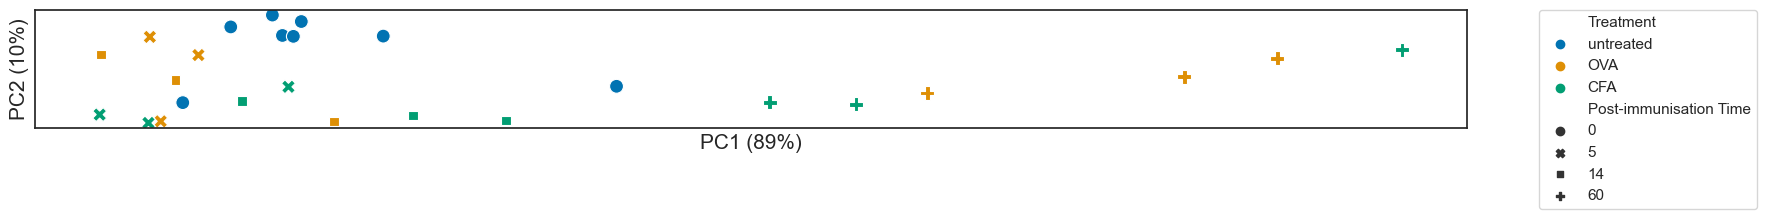

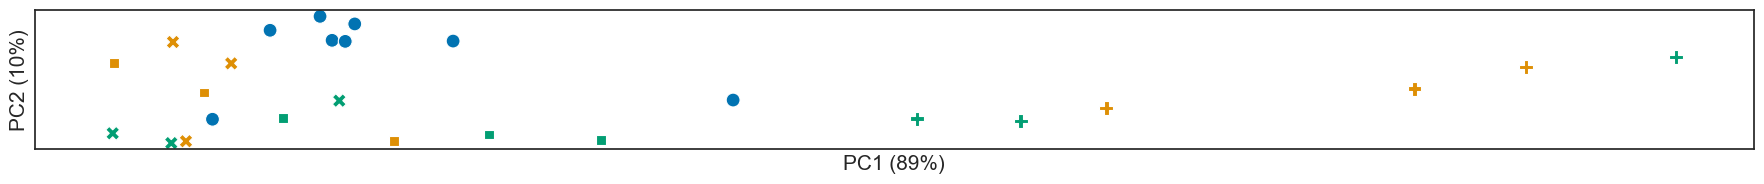

In [133]:
plotPCA(pca_qDZ_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_scaled, wdir_path, "PCA_qDZ_w_legend.pdf", True)

plotPCA(pca_qDZ_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_scaled, wdir_path, "PCA_qDZ.pdf", False)





### PCA on identity qD

In [134]:
col_without_identity = [colname for colname in list(divP1_all_df) if "L" in colname] 
col_without_identity = [colname for colname in col_without_identity if "identity" not in colname] 

In [135]:
divP1_identity_treatment_time = divP1_all_df.drop(["sample_name", 
                                                               "library", 
                                                               "sample_type", 
                                                               "unique_CDR3s"
                                                  ] + col_without_identity, axis=1)









divP1_identity_treatment_time



L_identity_q_0 L_identity_q_1 L_identity_q_2 L_identity_q_3 L_identity_q_4  \
0       10.382668       9.923739       8.372279       7.036656       6.412983   
1       10.326825       9.820479       8.396385       7.263158        6.71513   
2        10.31331        9.79213       8.100211       6.797395       6.225713   
3       10.246013       9.575262       7.577281       6.362968       5.830811   
4       10.264618       9.661774       7.634989       6.329691       5.786627   
5        9.606832        7.06856       4.020438       3.251835       2.928516   
6        9.976087       9.062567       7.001029       5.942707       5.461566   
7        9.986311       8.181686        5.40985       4.617796       4.263005   
8       10.375895       9.827401       7.646447       6.153441       5.541584   
9       10.326137       9.824799       8.409804       7.173725       6.543145   
10      10.351852       9.391342       5.400699        4.11813       3.664288   
11      10.381676       9.615025       6.008304       4.585112       4.079247   
12      10.291908       9.514309       6.036021       4.613508       4.105029   
13      10.322198       9.270683       5.413999       4.152416       3.696211   
14      10.208469        8.78081       4.458242       3.389746       3.015706   
15      10.410004       9.965362        8.27124       6.745656       6.055319   
16      10.143881        8.58955       4.215854        3.20557       2.852566   
17      10.144275       8.236502       3.537238       2.677041       2.381074   
18      10.209353       9.156922       5.606193       4.358172       3.898265   
19      10.377265       9.742716       6.919799       5.376013       4.789254   
20       9.933435       6.929036       2.376032        1.78866       1.590088   
21        9.88461       6.877244       2.442972       1.839242       1.635042   
22      10.049577       7.581359       2.833092       2.132474        1.89572   
23       9.651108       5.324217       1.523847       1.145975       1.018719   
24        9.69591       5.713925        1.74229       1.311347       1.165772   
25       9.796236       5.993273       1.797439         1.3515       1.201407   

   L_identity_q_5 L_identity_q_6 L_identity_q_11  Treatment  \
0        6.070457       5.854117        4.903576  untreated   
1        6.402802       6.199004        5.221356  untreated   
2        5.923223       5.737541         4.94766  untreated   
3         5.53916       5.355951        4.558287  untreated   
4        5.498708       5.320486         4.53192  untreated   
5        2.754211       2.646466        2.206366  untreated   
6        5.184441       5.003084        4.187777  untreated   
7        4.055372       3.918524        3.288226  untreated   
8        5.220811       5.023489        4.197042        OVA   
9        6.182602       5.952199        4.970454        OVA   
10       3.435642       3.298263         2.74856        OVA   
11       3.824624       3.671679        3.059738        CFA   
12        3.84884        3.69493        3.079114        CFA   
13       3.465669       3.327097        2.772589        CFA   
14       2.827485       2.714418        2.262019        OVA   
15       5.688548       5.464007        4.554477        OVA   
16       2.674665       2.567733        2.139786        CFA   
17       2.232401       2.143121        1.785936        CFA   
18       3.661105       3.516666        2.931444        CFA   
19       4.490918       4.311394        3.592842        OVA   
20       1.490714       1.431086        1.192571        OVA   
21       1.532858       1.471544        1.226287        CFA   
22       1.777246       1.706157        1.421797        CFA   
23       0.955052        0.91685        0.764042        CFA   
24       1.092916         1.0492        0.874333        OVA   
25       1.126322       1.081269        0.901057        OVA   

    Post-immunisation Time  
0                        0  
1                        0  
2                        0

In [136]:
observables = [col for col in list(divP1_identity_treatment_time) if col != "Treatment"]
observables = [obs for obs in observables if obs != "Post-immunisation Time"]
# Separating out the features
x_qDZ_identity1 = divP1_identity_treatment_time.loc[:, observables].values
# Separating out the target
y_qDZ_identity1 = divP1_identity_treatment_time.loc[:,'Treatment'].values

In [137]:
x_qDZ_identity1.shape

(26, 8)

In [138]:
x_qDZ_identity1.mean(), x_qDZ_identity1.std()

(5.352664129670231, 2.960403958664578)

In [139]:
x_qDZ_identity1_scaled = StandardScaler().fit_transform(x_qDZ_identity1)

In [140]:
x_qDZ_identity1_scaled.mean(), x_qDZ_identity1_scaled.std()

(3.005074821461361e-16, 1.0)

In [141]:
pca_qDZ_identity1_scaled = decomposition.PCA(n_components=8)
principalComponents_qDZ_identity1_scaled = pca_qDZ_identity1_scaled.fit_transform(x_qDZ_identity1_scaled)

principalDf_qDZ_identity1_scaled = pd.DataFrame(data = principalComponents_qDZ_identity1_scaled)
principalDf_qDZ_identity1_scaled.columns = ["PC_" + str(pc) for pc in list(principalDf_qDZ_identity1_scaled)]
finalDf_qDZ_identity1_scaled = pd.concat([principalDf_qDZ_identity1_scaled, divP1_identity_treatment_time[["Treatment", "Post-immunisation Time"]]], axis = 1)



/var/folders/17/_lw60vw13_14_qf0rgqb1jdh0000gn/T/ipykernel_50280/2086500981.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


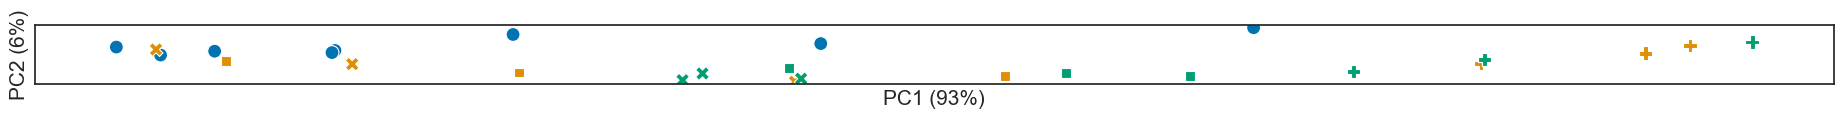

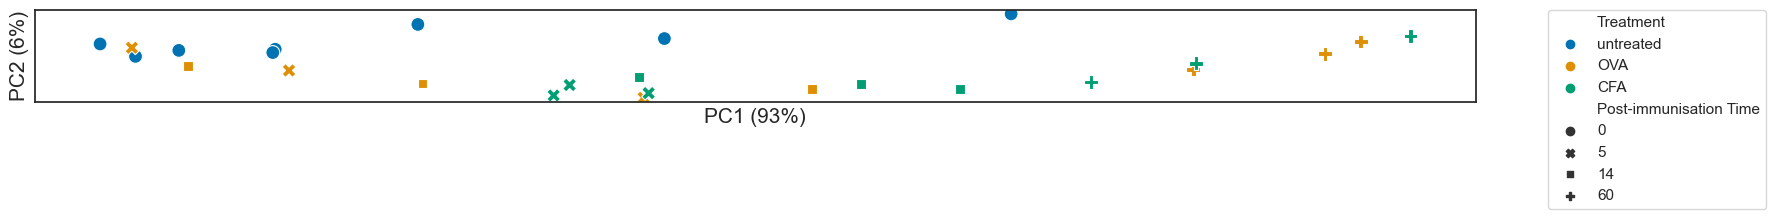

In [142]:
plotPCA(pca_qDZ_identity1_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_identity1_scaled, wdir_path, "PCA_qDZ_identity.pdf", False)

plotPCA(pca_qDZ_identity1_scaled, "Treatment", "Post-immunisation Time", 
        finalDf_qDZ_identity1_scaled, wdir_path, "PCA_qDZ_identity_w_legend.pdf", True)






### Exp(Shannon index) separation 

In [143]:
divP1_identity_q1_treatment_time = divP1_all_df[["L_identity_q_1", "Post-immunisation Time", "Treatment"]]

divP1_identity_q1_treatment_time



L_identity_q_1  Post-immunisation Time  Treatment
0        9.923739                       0  untreated
1        9.820479                       0  untreated
2         9.79213                       0  untreated
3        9.575262                       0  untreated
4        9.661774                       0  untreated
5         7.06856                       0  untreated
6        9.062567                       0  untreated
7        8.181686                       0  untreated
8        9.827401                       5        OVA
9        9.824799                       5        OVA
10       9.391342                       5        OVA
11       9.615025                       5        CFA
12       9.514309                       5        CFA
13       9.270683                       5        CFA
14        8.78081                      14        OVA
15       9.965362                      14        OVA
16        8.58955                      14        CFA
17       8.236502                      14        CFA
18       9.156922                      14        CFA
19       9.742716                      14        OVA
20       6.929036                      60        OVA
21       6.877244                      60        CFA
22       7.581359                      60        CFA
23       5.324217                      60        CFA
24       5.713925                      60        OVA
25       5.993273                      60        OVA

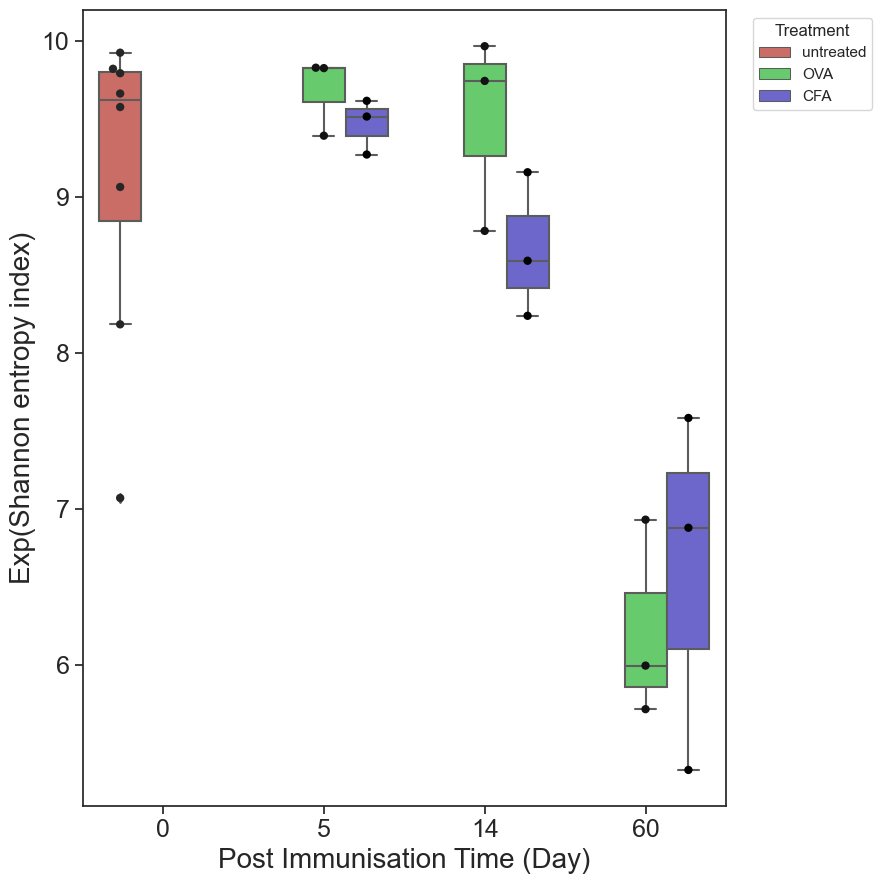

In [144]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP1_identity_q1_treatment_time["Treatment"]))))
p = sns.boxplot(x="Post-immunisation Time", y="L_identity_q_1", hue="Treatment",
                 data=divP1_identity_q1_treatment_time, palette=cmap)
p = sns.swarmplot(x="Post-immunisation Time", y="L_identity_q_1", hue="Treatment",data=divP1_identity_q1_treatment_time, 
                  color="black", 
                  dodge = "True", 
                 size = 6)

# get legend information from the plot object
handles, labels = p.get_legend_handles_labels()
# specify just one legend
l = p.legend(handles[0:len(list(set(divP1_identity_q1_treatment_time["Treatment"])))], labels[0:len(list(set(divP1_identity_q1_treatment_time["Treatment"])))], 
                   title = "Treatment", loc=2, bbox_to_anchor=(1.03, 1))


plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Post Immunisation Time (Day)", fontsize = 20)
plt.ylabel("Exp(Shannon entropy index)", fontsize = 20)
plt.tight_layout()
plt.savefig(wdir_path + "Exp_Shannon_entropy_barplot.pdf")

### Gini analogue separation

In [145]:
divP1_identity_q2_treatment_time = divP1_all_df[["L_identity_q_2", "Post-immunisation Time", "Treatment"]]

divP1_identity_q2_treatment_time



L_identity_q_2  Post-immunisation Time  Treatment
0        8.372279                       0  untreated
1        8.396385                       0  untreated
2        8.100211                       0  untreated
3        7.577281                       0  untreated
4        7.634989                       0  untreated
5        4.020438                       0  untreated
6        7.001029                       0  untreated
7         5.40985                       0  untreated
8        7.646447                       5        OVA
9        8.409804                       5        OVA
10       5.400699                       5        OVA
11       6.008304                       5        CFA
12       6.036021                       5        CFA
13       5.413999                       5        CFA
14       4.458242                      14        OVA
15        8.27124                      14        OVA
16       4.215854                      14        CFA
17       3.537238                      14        CFA
18       5.606193                      14        CFA
19       6.919799                      14        OVA
20       2.376032                      60        OVA
21       2.442972                      60        CFA
22       2.833092                      60        CFA
23       1.523847                      60        CFA
24        1.74229                      60        OVA
25       1.797439                      60        OVA

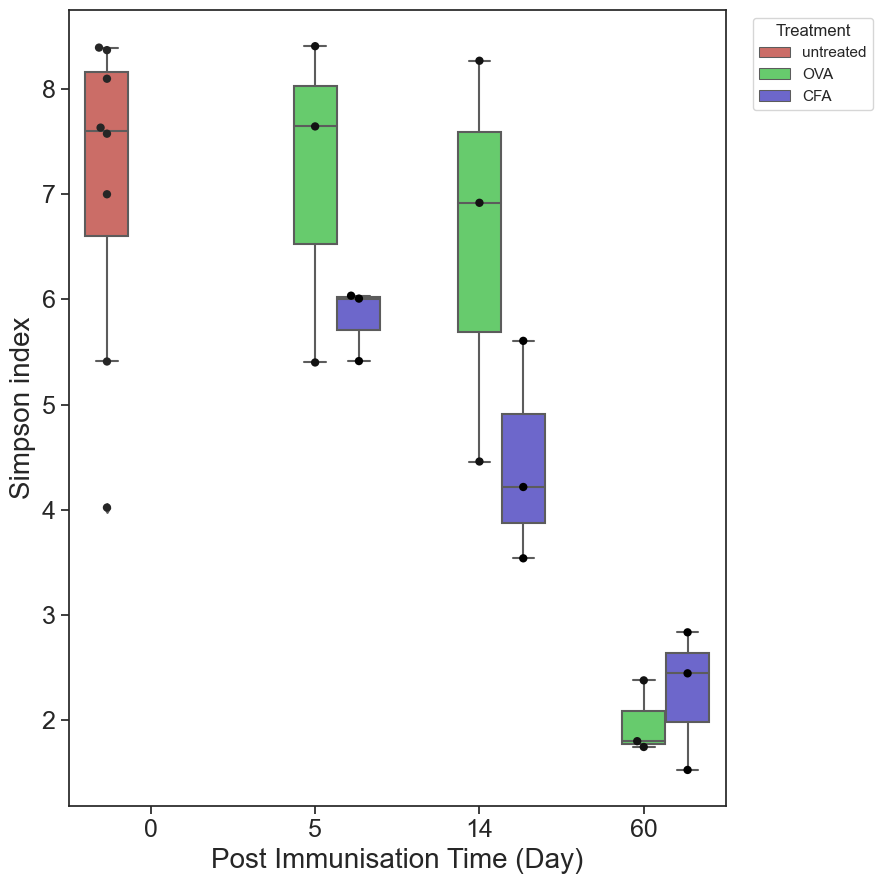

In [146]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP1_identity_q2_treatment_time["Treatment"]))))
p = sns.boxplot(x="Post-immunisation Time", y="L_identity_q_2", hue="Treatment",
                 data=divP1_identity_q2_treatment_time, palette=cmap)
p = sns.swarmplot(x="Post-immunisation Time", y="L_identity_q_2", hue="Treatment",data=divP1_identity_q2_treatment_time, 
                  color="black", 
                  dodge = "True", 
                 size = 6)
# get legend information from the plot object
handles, labels = p.get_legend_handles_labels()
# specify just one legend
l = p.legend(handles[0:len(list(set(divP1_identity_q2_treatment_time["Treatment"])))], labels[0:len(list(set(divP1_identity_q2_treatment_time["Treatment"])))], 
                   title = "Treatment", loc=2, bbox_to_anchor=(1.03, 1))


#p.legend(title = "Treatment", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Post Immunisation Time (Day)", fontsize = 20)
plt.ylabel("Simpson index", fontsize = 20)

plt.tight_layout()
plt.savefig(wdir_path + "Gini_Simpson_index_barplot.pdf")

### Shannon vs Gini-Simpson 

In [147]:
divP_Shannon_Gini = divP1_identity_q2_treatment_time.copy()
divP_Shannon_Gini["L_identity_q_1"] = divP1_identity_q1_treatment_time["L_identity_q_1"]
divP_Shannon_Gini

L_identity_q_2  Post-immunisation Time  Treatment L_identity_q_1
0        8.372279                       0  untreated       9.923739
1        8.396385                       0  untreated       9.820479
2        8.100211                       0  untreated        9.79213
3        7.577281                       0  untreated       9.575262
4        7.634989                       0  untreated       9.661774
5        4.020438                       0  untreated        7.06856
6        7.001029                       0  untreated       9.062567
7         5.40985                       0  untreated       8.181686
8        7.646447                       5        OVA       9.827401
9        8.409804                       5        OVA       9.824799
10       5.400699                       5        OVA       9.391342
11       6.008304                       5        CFA       9.615025
12       6.036021                       5        CFA       9.514309
13       5.413999                       5        CFA       9.270683
14       4.458242                      14        OVA        8.78081
15        8.27124                      14        OVA       9.965362
16       4.215854                      14        CFA        8.58955
17       3.537238                      14        CFA       8.236502
18       5.606193                      14        CFA       9.156922
19       6.919799                      14        OVA       9.742716
20       2.376032                      60        OVA       6.929036
21       2.442972                      60        CFA       6.877244
22       2.833092                      60        CFA       7.581359
23       1.523847                      60        CFA       5.324217
24        1.74229                      60        OVA       5.713925
25       1.797439                      60        OVA       5.993273

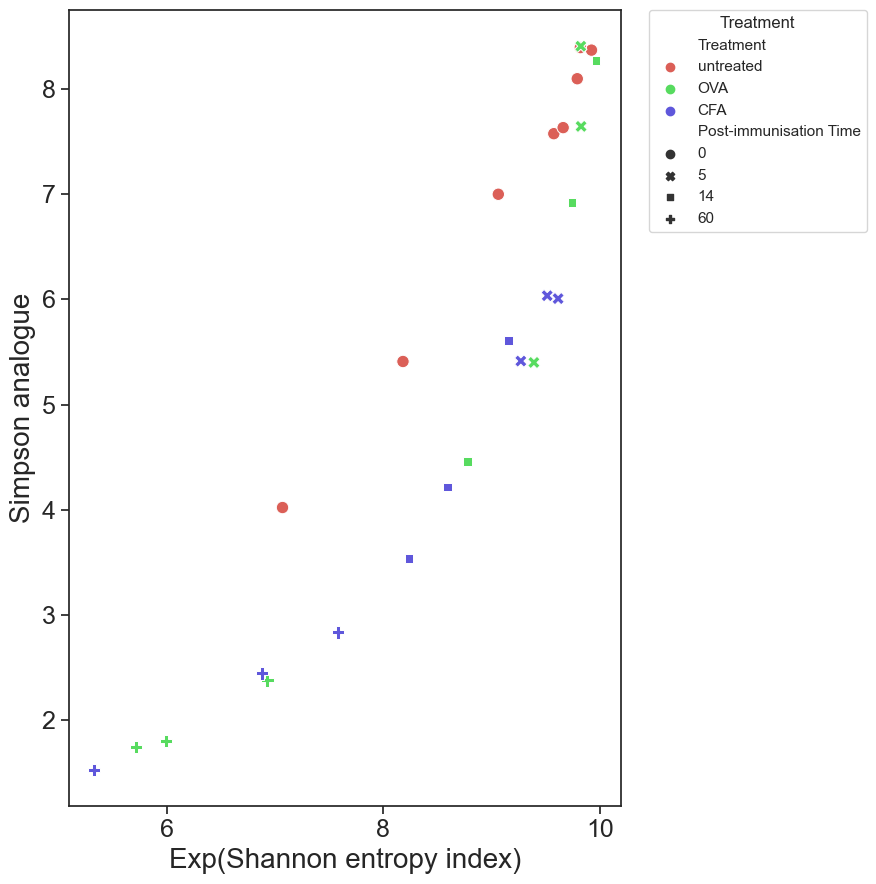

In [148]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.color_palette("hls", len(list(set(divP_Shannon_Gini["Treatment"]))))
p = sns.scatterplot(x="L_identity_q_1", y="L_identity_q_2", 
                     data=divP_Shannon_Gini,
                     hue="Treatment", palette=cmap,  
                     style = "Post-immunisation Time", 
                    s = 80
                   )




p.legend(title = "Treatment", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Exp(Shannon entropy index)", fontsize = 20)
plt.ylabel("Simpson analogue", fontsize = 20)
plt.tight_layout()
plt.savefig(wdir_path + "Shannon_vs_Gini_Simpson_index_scatter_plot.pdf")




# Hierarchical clustering 

## Cluster divP features 

In [149]:
divP_features_HC = divP_features_treatment_time.copy()

divP_features_HC = divP_features_HC.set_index(["Treatment", "Post-immunisation Time"])

divP_features_HC

identity_64.0_area  identity_32.0_area  \
Treatment Post-immunisation Time                                           
untreated 0                                 0.044564            0.575735   
          0                                 0.049612            0.656132   
          0                                 0.051425            0.641020   
          0                                 0.053344            0.616943   
          0                                 0.054695            0.646004   
          0                                 0.039508            0.431304   
          0                                 0.060616            0.615198   
          0                                 0.018735            0.247261   
OVA       5                                 0.029676            0.410933   
          5                                 0.031215            0.401233   
          5                                 0.020418            0.260011   
CFA       5                                 0.020625            0.260989   
          5                                 0.031801            0.397808   
          5                                 0.019928            0.251584   
OVA       14                                0.022708            0.270835   
          14                                0.029759            0.383435   
CFA       14                                0.029723            0.330584   
          14                                0.022280            0.298423   
          14                                0.025678            0.321831   
OVA       14                                0.025712            0.333345   
          60                                0.026321            0.314896   
CFA       60                                0.019890            0.250281   
          60                                0.021701            0.315776   
          60                                0.018115            0.231505   
OVA       60                                0.018135            0.233357   
          60                                0.020476            0.273722   

                                  identity_16.0_area  identity_8.0_area  \
Treatment Post-immunisation Time                                          
untreated 0                                 5.366205          21.165990   
          0                                 6.310619          22.950594   
          0                                 5.482111          20.754404   
          0                                 4.661354          17.973526   
          0                                 4.970509          18.331852   
          0                                 2.740125           7.312469   
          0                                 4.316685          16.339166   
          0                                 2.449207           8.742486   
OVA       5                                 4.162660          16.269327   
          5                                 4.623619          20.702831   
          5                                 2.808258           9.337865   
CFA       5                                 2.866302           9.750066   
          5                                 3.420638          11.299709   
          5                                 2.679394           9.185865   
OVA       14                                2.698008           8.274177   
          14                                4.142118          18.035888   
CFA       14                                2.873220           8.226948   
          14                                2.766212           7.599680   
          14                                2.998693           9.697147   
OVA       14                                3.409365          12.579606   
          60                                2.547338           6.589170   
CFA       60                                2.287108           6.349492   
          60                                2.770024           7.154925   
          60                  

<Figure size 600x800 with 0 Axes>

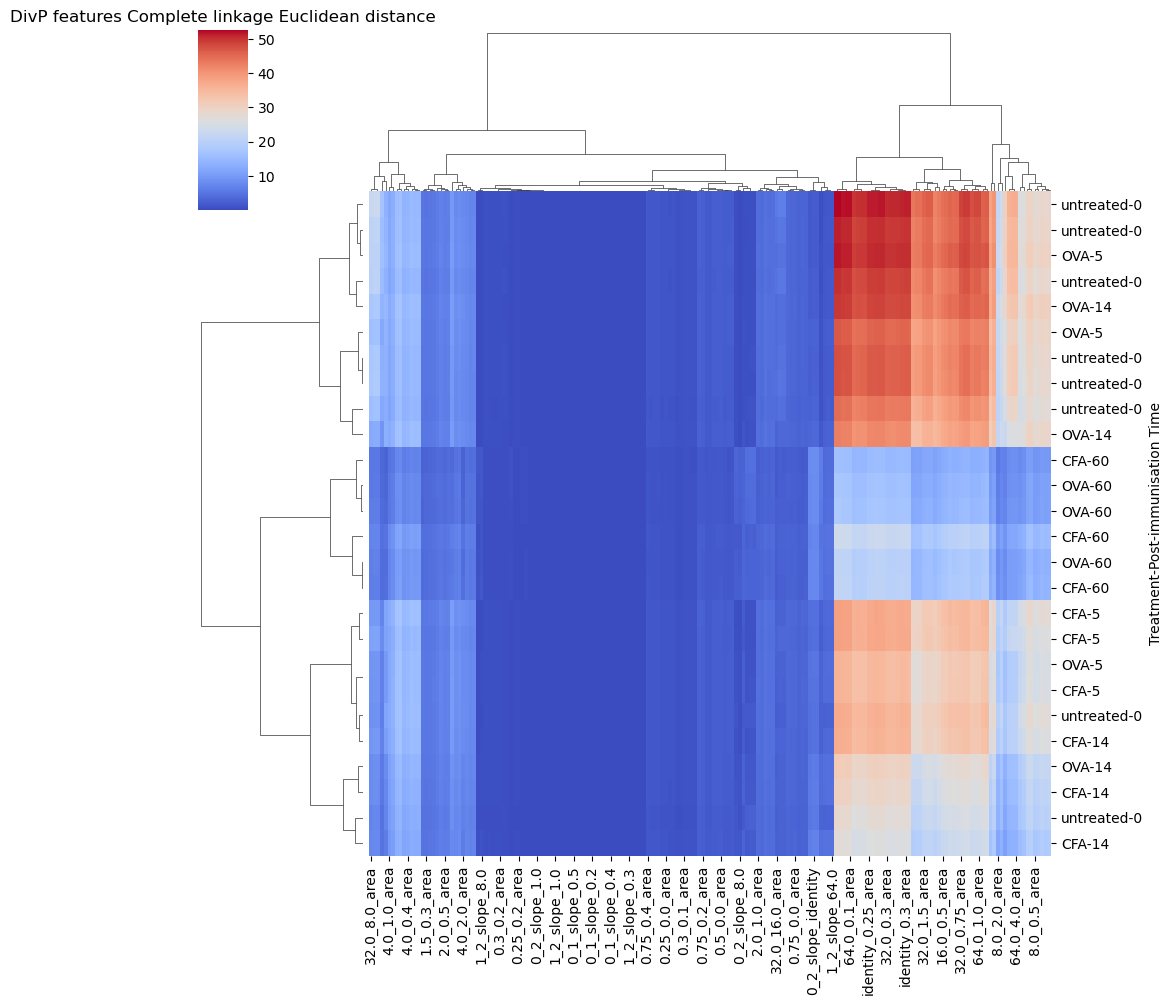

In [150]:
matplotlib.rc_file_defaults()
plt.figure(figsize=(6,8))
ax = sns.clustermap(divP_features_HC,
               method='complete',
                metric='euclidean',
              cmap="coolwarm")

if not os.path.isdir(wdir_path+"heatmaps/"):
        os.makedirs(wdir_path+"heatmaps/", exist_ok=False)
    
plt.title("DivP features Complete linkage Euclidean distance")
plt.savefig(wdir_path + "heatmaps/HC_divP_features.png", bbox_inches='tight')


## Cluster true diversity

In [151]:
divP_qDZ_HC = divP1_all_df.copy()

divP_qDZ_HC = divP_qDZ_HC.set_index(["Treatment", "Post-immunisation Time"])

divP_qDZ_HC = divP_qDZ_HC.drop(["unique_CDR3s", "library", "sample_name", "sample_type"], axis = 1)
divP_qDZ_HC

L_0.1_q_0 L_0.1_q_1 L_0.1_q_2 L_0.1_q_3  \
Treatment Post-immunisation Time                                           
untreated 0                       0.061487   0.06148  0.061474  0.061467   
          0                       0.060581  0.060574  0.060566  0.060559   
          0                       0.060332  0.060324  0.060317  0.060309   
          0                       0.061066  0.061059  0.061052  0.061045   
          0                       0.060892  0.060883  0.060873  0.060864   
          0                       0.058304  0.058291  0.058278  0.058264   
          0                       0.059804  0.059793  0.059782  0.059771   
          0                       0.064595  0.064588   0.06458  0.064572   
OVA       5                       0.062592  0.062584  0.062576  0.062568   
          5                       0.062908    0.0629  0.062891  0.062883   
          5                       0.065091   0.06508  0.065069  0.065058   
CFA       5                       0.065782  0.065772  0.065762  0.065751   
          5                       0.062209  0.062198  0.062188  0.062177   
          5                       0.065343  0.065331   0.06532  0.065308   
OVA       14                      0.062937   0.06292  0.062904  0.062887   
          14                      0.064034  0.064026  0.064018  0.064011   
CFA       14                      0.061671  0.061655  0.061639  0.061623   
          14                      0.060717  0.060698  0.060678  0.060659   
          14                      0.063407  0.063399   0.06339  0.063382   
OVA       14                      0.063563  0.063554  0.063546  0.063538   
          60                      0.054753  0.054701  0.054649  0.054597   
CFA       60                      0.056369  0.056307  0.056246  0.056184   
          60                      0.056934  0.056896  0.056858   0.05682   
          60                      0.047466  0.047349  0.047232  0.047116   
OVA       60                      0.051535  0.051439  0.051342  0.051246   
          60                      0.049112  0.049021   0.04893  0.048838   

                                 L_0.1_q_4 L_0.1_q_5 L_0.1_q_6 L_0.1_q_11  \
Treatment Post-immunisation Time                                            
untreated 0                       0.061461  0.061455  0.061448   0.052575   
          0                       0.060552  0.060544  0.060537   0.051832   
          0                       0.060302  0.060294  0.060287   0.051228   
          0                       0.061039  0.061032  0.061025   0.052254   
          0                       0.060854  0.060845  0.060835   0.051793   
          0                       0.058251  0.058237  0.058224   0.049584   
          0                       0.059761   0.05975  0.059739   0.050358   
          0                       0.064565  0.064557  0.064549   0.056379   
OVA       5                        0.06256  0.062552  0.062543   0.053995   
          5                       0.062875  0.062867  0.062859   0.054136   
          5                       0.065046  0.065035  0.065024   0.056269   
CFA       5                       0.065741  0.065731  0.065721   0.056344   
          5                       0.062167  0.062157  0.062146    0.05323   
          5                       0.065296  0.065285  0.065273   0.056347   
OVA       14                       0.06287  0.062854  0.062837   0.052629   
          14                      0.064003  0.063995  0.063987   0.055507   
CFA       14                      0.061607  0.061591  0.061576   0.052043   
          14                       0.06064  0.060621  0.060601   0.050643   
          14                      0.063374  0.063366  0.063358   0.054415   
OVA       14                       0.06353  0.063522  0.063514   0.054813   
          60                      0.054545  0.054493  0.054441   0.041183   
CFA       60                      0.056122   0.05606  0.055998   0.041227   
          60                      0.056782  0.056744  0.

In [152]:
divP_qDZ_HC.isnull().values.any()

False

In [153]:
divP_qDZ_HC = divP_qDZ_HC.apply(pd.to_numeric) 

In [154]:
divP_qDZ_HC.dtypes

L_0.1_q_0          float64
L_0.1_q_1          float64
L_0.1_q_2          float64
L_0.1_q_3          float64
L_0.1_q_4          float64
                    ...   
L_identity_q_3     float64
L_identity_q_4     float64
L_identity_q_5     float64
L_identity_q_6     float64
L_identity_q_11    float64
Length: 128, dtype: object

<Figure size 600x800 with 0 Axes>

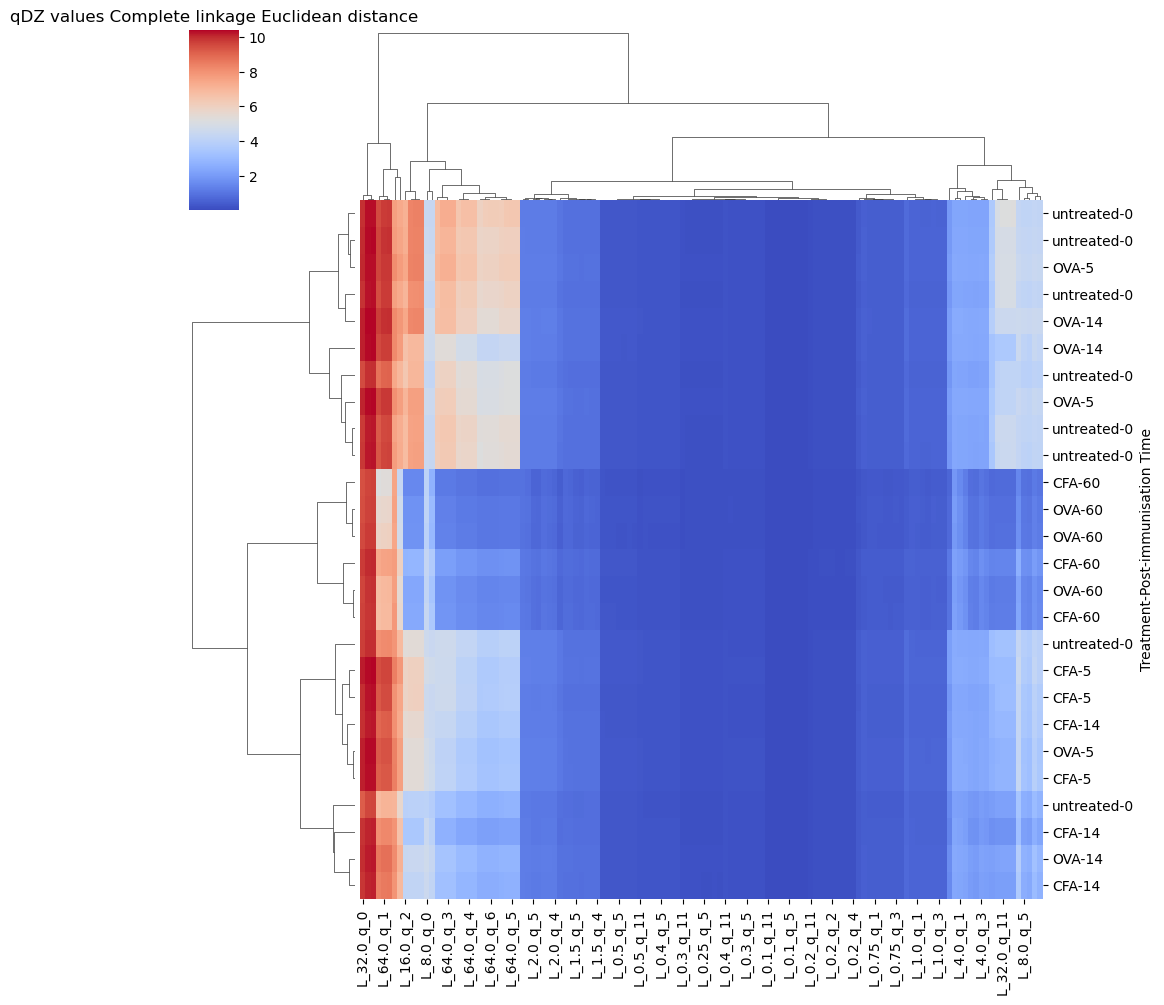

In [155]:
matplotlib.rc_file_defaults()
plt.figure(figsize=(6,8))
ax = sns.clustermap(divP_qDZ_HC,
               method='complete',
                metric='euclidean',
                cmap="coolwarm"
                   )
if not os.path.isdir(wdir_path+"heatmaps/"):
        os.makedirs(wdir_path+"heatmaps/", exist_ok=False)
    
plt.title("qDZ values Complete linkage Euclidean distance")
plt.savefig(wdir_path + "heatmaps/HC_qDZ.png", bbox_inches='tight')
